In [350]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as std
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture


mls = pd.read_csv('c:/Users/sgfis/downloads/mls_update.csv')

mls.columns = mls.columns.str.lower()
mls.columns = mls.columns.str.replace(' ', '_')

In [351]:
! pip install gower

In [352]:
import gower

# General EDA

With my data set imported, it's time to do some EDA on the types. The goal of this project is to perform some unsupervised learning clustering on a set of residential data that I am familiar with, in hopes of gaining new insights into relationships between the properties.

In [353]:
mls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6908 entries, 0 to 6907
Data columns (total 74 columns):
parcel_number                                6908 non-null object
class                                        6908 non-null object
county                                       6908 non-null object
price                                        6907 non-null object
list_date                                    6908 non-null object
list_price                                   6908 non-null object
selling_price                                6907 non-null object
selling_price.1                              0 non-null float64
days_on_market                               6908 non-null int64
days_on_mls                                  6908 non-null int64
closed_date                                  6907 non-null object
date_history_status                          6908 non-null object
price_/_sqft                                 0 non-null float64
list_price_/_sqft                        

Dropping the columns that have no input values or are providing information that is not valuable to this analysis.

Note on dropped values: dropping address because parcel ID is a good reference for the specific property. Dropping state / city / county since all properties share the same values for these features 

In [354]:
mls_df =  mls.drop(columns = ['selling_price.1', 'addtrentyn', '#_tenants', 
                              '#_floors', 'cap_rate_%', 'condition.1', 'date_leased', 'number_of_acres',
                              'pass_thru_exp/sf_annual', 'price/sqft_annual', 'price/sqft_monthly',
                              'total_#_of_units','net_operating_income', 'price_/_sqft','open_house_y/n', 'class',
                             'geocode_quality', 'attachment_count', 'range', 'county', 'city', 'state', 
                             'address'])

mls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6908 entries, 0 to 6907
Data columns (total 51 columns):
parcel_number                                6908 non-null object
price                                        6907 non-null object
list_date                                    6908 non-null object
list_price                                   6908 non-null object
selling_price                                6907 non-null object
days_on_market                               6908 non-null int64
days_on_mls                                  6908 non-null int64
closed_date                                  6907 non-null object
date_history_status                          6908 non-null object
list_price_/_sqft                            6908 non-null object
sold_price/sqft                              6908 non-null object
original_price                               6906 non-null object
date_price_change                            6897 non-null object
how_sold_code                        

In [355]:
mls_df.head()

,parcel_number,price,list_date,list_price,selling_price,days_on_market,days_on_mls,closed_date,date_history_status,list_price_/_sqft,sold_price/sqft,original_price,date_price_change,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,listing_type,listing_visibility_type,for_comp_purposes_only_y/n,mls_only_entry_y/n_(no_services_provided),...,short_sale_y/n,taxes_-_annual,#_of_garage_spaces,garage_y/n,pool_y/n,zoning,bank_owned_y/n,auction,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,neighborhood_amenities,outbuilding_features,style,floors,interior_layout,terms,lot_info,total_sqft_under_roof,waterfront_y/n,parcel_size_(acres)
0,06081-010-003,NaN,1/8/2018,"$153,500",NaN,297,296,NaN,11/1/2018,$128.78,$0.00,"$157,000",11/1/2018,NaN,32605,"1,192",1984,2,3,0,NaN,Exclusive Right of Sale,MLS Listing,No,No,...,No,"$1,683",1,Yes,No,NaN,No,No,Shingle,Frame,Wood,NaN,"Single Vanity, Tub/Shower Combo","Cooktop - Gas, Dishwasher, Oven - Gas",Privacy,NaN,Workshop,Ranch,Tile,"Laundry in Garage, Master Downstairs, Storage ...","Cash, Conventional, FHA, May Pay Closing Costs...",Square-shaped,"1,495",No,0.28
1,11592-000-000,"$10,000",10/31/2017,"$17,900","$10,000",177,176,5/25/2018,5/31/2018,$18.45,$10.31,"$24,900",5/31/2018,CASH,32609,970,1900,1,2,0,Handyman Special,Exclusive Right of Sale,MLS Listing,No,No,...,No,"$1,052",NaN,No,No,NaN,Undisclosed,No,Shingle,Foundation-Crawlsp/Piers,Vinyl,Kit/Din Combo,Single Vanity,None,Chain Link,NaN,Storage Shed,Ranch,Wood - Hardwood,Bonus (Not Inc in Bd #),Cash,Rectangular-shaped,"1,030",No,0.15
2,10733-005-000,"$16,000",1/4/2016,"$40,000","$16,000",965,965,9/28/2018,9/28/2018,$69.93,$27.97,"$40,000",9/28/2018,CASH,32641,572,1979,1,2,0,Other,Exclusive Right of Sale,MLS Listing,No,No,...,No,$629,NaN,No,No,NaN,No,No,Shingle,Frame,Conventional Stucco,Kit/Din Combo,Single Vanity,"Cooktop - Electric, Oven - Electric, Refrigerator",Wood,NaN,None,A Frame,"Carpet, Vinyl",Other,"Cash, Conventional, FHA, VA",Corner Lot,NaN,No,0.09
3,16054-006-000,"$17,000",4/2/2018,"$17,000","$17,000",137,137,8/17/2018,8/23/2018,$11.77,$11.77,"$17,000",4/2/2018,CASH,32641,"1,444",1950,2,3,0,Other,Exclusive Right of Sale,MLS Listing,No,No,...,No,$164,NaN,No,No,NaN,No,No,Flat,Brick,Vinyl,Other,Walk-In Tub,Refrigerator,Chain Link,NaN,Other,Ranch,Other,Other,Cash,Cul-de-sac,"1,508",No,0.19
4,11213-000-000,"$18,000",5/12/2017,"$18,500","$18,000",91,85,10/3/2017,10/19/2017,$27.21,$26.47,"$24,500",10/19/2017,CASH,32641,680,1940,1,2,0,NaN,Exclusive Right of Sale,MLS Listing,No,No,...,No,$690,NaN,No,No,NaN,No,No,Metal,Frame,Wood,NaN,Tub/Shower Combo,None,Chain Link,NaN,None,A Frame,Wood - Hardwood,"Living Room, Other","Cash, Conventional, Other",Rectangular-shaped,912,No,0.34


## Fixing Price and Converting obj to ints

There are a ton of price variables, so it's time to test for redundacy

In [356]:
mls_df.loc[:,['price', 'list_price','list_price_/_sqft', 'original_price', 'selling_price', 'sold_price/sqft']]

,price,list_price,list_price_/_sqft,original_price,selling_price,sold_price/sqft
0,NaN,"$153,500",$128.78,"$157,000",NaN,$0.00
1,"$10,000","$17,900",$18.45,"$24,900","$10,000",$10.31
2,"$16,000","$40,000",$69.93,"$40,000","$16,000",$27.97
3,"$17,000","$17,000",$11.77,"$17,000","$17,000",$11.77
4,"$18,000","$18,500",$27.21,"$24,500","$18,000",$26.47
...,...,...,...,...,...,...
6903,"$1,700,000","$1,700,000",$409.15,"$1,700,000","$1,700,000",$409.15
6904,"$1,750,000","$1,850,000",$179.87,"$1,850,000","$1,750,000",$170.15
6905,"$1,750,000","$1,850,000","$1,761.90","$3,000,000","$1,750,000","$1,666.67"
6906,"$1,796,929","$1,796,929",$240.01,"$1,796,929","$1,796,929",$240.01


I see some redundancy with price / selling_price. Since selling_price is clearer I'll drop price. I'm also dropping original price because that represents a price change, and it's hard to determine if the price was changed because of the decision of the owner or an input error by the agent - so it's not what I would consider a reliable metric.

In [357]:
resmls_df = mls_df.drop(columns = ['price', 'original_price'])

All of my prices are coming up as objects, likely due to the $. I'll need to strip and convert them to floats or ints before continuing my EDA

In [358]:
for column_name in ["list_price", "selling_price"]:
    print("These are the problematic values for the variable: {}".format(column_name))
    for value in resmls_df[column_name]:
        try:
            float(value)
        except:
            print(value)

These are the problematic values for the variable: list_price
$153,500
$17,900
$40,000
$17,000
$18,500
$40,000
$25,000
$35,000
$35,000
$27,000
$22,000
$30,000
$34,125
$30,000
$27,900
$26,000
$25,000
$45,000
$37,900
$29,900
$32,000
$18,000
$27,000
$29,900
$28,000
$29,900
$29,900
$55,000
$35,000
$39,900
$39,900
$35,000
$30,000
$18,000
$34,900
$34,900
$35,000
$33,000
$36,000
$39,900
$34,900
$34,950
$50,000
$50,000
$33,900
$33,500
$35,000
$29,900
$44,900
$39,000
$31,000
$29,900
$28,000
$48,500
$39,900
$39,900
$57,499
$35,000
$20,000
$36,000
$38,500
$39,900
$40,000
$43,400
$65,900
$30,000
$59,900
$22,000
$52,000
$45,000
$54,900
$44,900
$36,000
$34,900
$39,900
$42,800
$40,000
$50,400
$45,900
$45,000
$42,000
$45,000
$49,900
$35,000
$39,000
$45,000
$45,000
$54,900
$64,900
$49,900
$59,900
$53,500
$51,000
$55,000
$68,500
$48,500
$53,900
$51,000
$56,900
$55,000
$49,900
$55,000
$54,900
$45,800
$59,500
$52,000
$54,900
$63,500
$62,500
$52,500
$39,500
$36,000
$59,000
$47,500
$50,000
$64,900
$130,000


$138,000
$129,900
$140,000
$136,000
$139,900
$149,900
$139,900
$138,500
$139,900
$159,900
$135,000
$142,000
$135,000
$138,900
$149,000
$145,000
$139,900
$149,500
$144,900
$135,900
$134,900
$146,900
$135,000
$129,000
$134,900
$139,900
$144,900
$157,000
$138,900
$139,900
$139,900
$149,900
$149,900
$139,900
$147,900
$139,900
$139,900
$154,900
$149,900
$149,000
$124,900
$139,900
$139,900
$140,000
$123,900
$139,900
$139,900
$144,500
$145,000
$142,000
$123,900
$149,000
$138,000
$145,000
$140,000
$139,500
$140,000
$129,900
$149,900
$139,000
$140,000
$139,000
$138,000
$139,900
$139,900
$149,900
$150,000
$149,000
$138,900
$149,000
$146,000
$149,900
$138,900
$144,000
$140,000
$143,000
$139,000
$139,900
$139,900
$142,000
$150,000
$139,000
$139,500
$137,000
$139,999
$139,739
$139,900
$144,980
$139,900
$139,900
$139,900
$139,900
$139,900
$137,000
$134,900
$145,000
$149,900
$140,000
$175,000
$149,900
$141,000
$142,000
$137,000
$157,000
$140,000
$144,900
$140,000
$137,500
$139,900
$145,000
$148,500
$

$175,000
$179,000
$184,900
$179,900
$184,900
$178,500
$177,500
$164,900
$182,000
$179,900
$176,950
$179,900
$179,500
$183,750
$178,000
$186,000
$179,900
$179,900
$177,000
$175,000
$184,900
$179,900
$178,000
$169,900
$182,000
$179,900
$178,000
$184,900
$189,000
$179,900
$178,707
$178,000
$182,200
$179,900
$185,000
$179,000
$178,000
$184,999
$185,000
$174,900
$184,900
$178,500
$179,900
$181,990
$175,000
$178,500
$179,900
$189,000
$179,900
$179,900
$179,000
$184,900
$184,900
$179,000
$179,900
$179,900
$192,900
$179,900
$179,000
$179,000
$179,000
$179,000
$184,900
$185,000
$188,900
$184,700
$179,900
$179,900
$179,900
$179,900
$179,900
$179,900
$189,999
$179,900
$179,900
$179,900
$184,900
$172,500
$189,900
$197,500
$199,900
$179,900
$192,500
$174,900
$210,000
$185,900
$183,500
$174,900
$193,000
$185,000
$179,000
$186,985
$185,000
$185,000
$179,900
$180,000
$249,999
$189,000
$184,900
$194,990
$180,000
$179,900
$184,900
$187,000
$180,000
$184,900
$182,000
$184,900
$198,900
$179,000
$184,900
$

$229,900
$229,000
$227,000
$239,000
$227,000
$229,999
$235,000
$227,500
$235,000
$227,500
$229,900
$229,900
$227,755
$227,900
$224,900
$227,500
$239,900
$229,900
$249,900
$249,900
$225,000
$234,900
$239,999
$229,900
$244,900
$235,000
$232,000
$225,000
$232,789
$233,900
$237,500
$229,000
$234,900
$229,000
$229,900
$239,900
$229,999
$229,000
$225,000
$227,500
$249,000
$249,707
$229,000
$229,000
$229,000
$229,500
$249,900
$229,000
$229,000
$229,900
$229,075
$229,500
$232,500
$227,500
$239,900
$229,800
$227,900
$229,900
$229,900
$229,900
$229,900
$229,900
$229,900
$229,999
$239,900
$237,900
$252,707
$225,000
$249,900
$245,999
$229,900
$239,900
$235,000
$234,900
$235,000
$279,000
$239,900
$239,900
$224,900
$233,302
$230,000
$239,000
$237,900
$239,900
$234,400
$239,900
$230,000
$225,000
$235,000
$229,900
$240,000
$230,000
$237,900
$229,900
$290,000
$239,000
$221,900
$239,900
$224,900
$230,000
$235,000
$239,000
$230,000
$224,000
$250,000
$239,000
$224,900
$235,000
$230,000
$240,000
$230,000
$

$260,000
$287,500
$279,000
$278,000
$279,000
$278,250
$277,886
$259,581
$282,707
$299,900
$278,706
$289,000
$279,000
$289,901
$279,000
$279,000
$294,900
$285,000
$289,500
$289,000
$279,900
$277,554
$284,900
$279,295
$277,832
$279,412
$279,900
$279,900
$284,900
$284,900
$289,900
$294,500
$304,900
$329,000
$285,000
$295,000
$290,000
$279,500
$299,900
$280,000
$289,900
$292,500
$287,900
$310,000
$280,000
$289,000
$289,000
$289,900
$284,900
$305,000
$280,000
$272,000
$294,000
$288,888
$289,000
$280,000
$299,950
$299,000
$290,000
$299,000
$285,000
$292,000
$299,000
$299,900
$299,900
$299,900
$274,900
$285,000
$288,500
$285,000
$280,680
$280,687
$273,017
$285,000
$285,000
$288,700
$281,350
$280,438
$281,500
$281,501
$289,900
$292,000
$278,000
$299,900
$289,000
$284,900
$279,000
$298,000
$289,000
$282,487
$285,500
$289,000
$289,900
$299,000
$284,900
$289,900
$287,000
$284,900
$293,900
$282,087
$283,262
$299,500
$289,900
$293,000
$299,900
$285,000
$249,800
$299,900
$293,000
$289,900
$284,900
$

$359,000
$369,500
$359,000
$355,000
$355,000
$365,000
$375,000
$367,000
$347,500
$340,505
$341,161
$345,816
$352,000
$343,500
$345,146
$346,297
$349,900
$337,257
$345,910
$357,000
$349,900
$369,900
$349,900
$344,751
$369,500
$359,900
$364,900
$348,413
$349,000
$354,900
$349,500
$352,500
$354,000
$349,887
$349,900
$349,900
$349,900
$349,900
$349,900
$385,000
$359,900
$355,000
$359,000
$359,900
$350,000
$359,900
$380,000
$350,000
$365,000
$359,900
$353,500
$379,900
$349,000
$359,895
$359,900
$375,000
$369,000
$365,000
$349,900
$350,000
$379,900
$365,000
$350,000
$499,000
$350,934
$350,000
$359,000
$349,900
$365,900
$359,900
$359,900
$384,000
$359,900
$364,900
$350,000
$359,900
$299,374
$341,657
$355,141
$359,000
$359,000
$343,802
$345,839
$352,500
$327,067
$350,000
$367,000
$359,000
$375,000
$349,000
$351,724
$374,000
$354,707
$362,421
$375,000
$369,000
$369,000
$395,000
$369,000
$364,900
$349,000
$369,900
$370,000
$379,000
$359,999
$355,000
$350,000
$399,000
$369,900
$379,900
$360,950
$

$699,900
$749,900
$725,000
$749,000
$750,000
$735,000
$769,000
$799,000
$743,800
$799,000
$775,000
$749,000
$769,000
$745,100
$745,305
$774,900
$799,900
$759,000
$765,000
$779,500
$774,900
$769,900
$875,000
$779,900
$730,000
$759,900
$774,900
$778,600
$750,000
$789,000
$799,900
$775,000
$784,900
$858,000
$771,500
$763,800
$769,000
$770,000
$799,900
$775,520
$825,000
$784,243
$798,350
$799,000
$799,000
$849,000
$795,000
$799,500
$829,900
$849,000
$800,836
$845,000
$879,900
$895,000
$849,000
$825,000
$849,000
$840,000
$895,000
$843,127
$845,000
$845,000
$849,500
$850,000
$859,900
$850,000
$889,500
$890,000
$870,000
$867,908
$868,000
$868,450
$869,000
$889,000
$874,000
$879,900
$899,900
$899,000
$895,000
$899,650
$899,000
$852,600
$940,000
$882,406
$893,800
$959,900
$889,000
$925,000
$948,000
$899,999
$869,999
$909,500
$939,000
$1,650,000
$912,040
$949,707
$925,000
$949,000
$945,000
$933,800
$928,504
$934,988
$942,218
$995,000
$957,100
$890,106
$970,000
$978,500
$1,100,000
$999,500
$991,9

$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,000
$145,500
$145,500
$146,000
$146,000
$146,000
$146,000
$146,000
$146,000
$146,000
$146,000
$146,000
$146,000
$146,000
$146,500
$146,500
$146,900
$147,000
$147,000
$147,000
$147,000
$147,000
$147,000
$147,000
$147,000
$147,000
$147,500
$147,500
$147,500
$147,500
$147,500
$147,500
$147,900
$147,900
$147,900
$148,000
$148,000
$148,000
$148,000
$148,000
$148,000
$148,000
$148,000
$148,000
$148,000
$148,000
$148,350
$148,500
$148,500
$148,500
$148,900
$148,900
$148,900
$149,000
$149,000
$149,000
$149,000
$149,000
$149,000
$149,000
$149,000
$149,000
$149,000
$149,000
$149,350
$149,500
$149,500
$149,500
$149,500
$149,500
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$149,900
$150,000
$150,000
$150,000
$150,000
$

$189,500
$189,500
$189,500
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$189,900
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,000
$190,640
$190,750
$190,900
$190,900
$191,000
$191,000
$191,000
$191,000
$191,500
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,000
$192,300
$192,500
$192,500
$192,500
$192,500
$192,500
$192,508
$192,900
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,000
$193,300
$193,400
$193,500
$

$241,400
$241,500
$241,500
$241,565
$241,650
$241,700
$241,750
$241,900
$241,900
$242,000
$242,000
$242,000
$242,000
$242,000
$242,000
$242,000
$242,000
$242,500
$242,500
$242,500
$242,500
$242,500
$242,500
$242,500
$242,500
$242,787
$242,900
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,000
$243,306
$243,500
$243,500
$243,500
$243,500
$243,800
$243,950
$244,000
$244,000
$244,000
$244,000
$244,000
$244,000
$244,000
$244,031
$244,113
$244,173
$244,500
$244,500
$244,700
$244,831
$244,900
$244,900
$244,900
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$245,000
$

$315,000
$315,000
$315,000
$315,000
$315,040
$315,897
$316,000
$316,000
$316,061
$316,251
$316,400
$316,571
$316,750
$316,750
$317,000
$317,000
$317,500
$317,500
$317,500
$318,000
$318,000
$318,000
$318,000
$318,000
$318,000
$318,000
$318,000
$318,000
$318,000
$318,000
$318,080
$318,400
$318,770
$319,000
$319,000
$319,000
$319,000
$319,000
$319,000
$319,000
$319,000
$319,000
$319,324
$319,514
$319,900
$319,900
$319,900
$319,917
$319,985
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,000
$320,500
$321,000
$321,011
$321,123
$321,500
$321,982
$322,000
$322,000
$322,000
$322,000
$322,316
$322,429
$323,000
$323,000
$323,000
$323,000
$323,500
$323,750
$324,000
$324,000
$324,000
$324,000
$324,440
$324,981
$325,000
$325,000
$325,000
$

$478,000
$478,571
$479,000
$479,000
$480,000
$480,000
$480,000
$480,000
$480,917
$481,000
$482,500
$483,000
$483,500
$485,000
$485,000
$485,000
$485,000
$485,000
$485,000
$485,000
$487,102
$488,000
$488,750
$489,000
$489,850
$489,900
$490,000
$490,000
$490,000
$490,000
$490,000
$490,000
$490,000
$490,150
$492,000
$492,000
$492,000
$492,500
$494,910
$495,000
$495,000
$495,000
$495,000
$495,000
$495,000
$495,000
$495,000
$495,735
$497,125
$499,000
$499,000
$499,000
$499,173
$499,900
$499,900
$499,999
$499,999
$500,000
$500,000
$500,000
$500,000
$500,000
$500,000
$500,000
$500,000
$500,000
$500,000
$500,000
$500,900
$501,149
$501,720
$502,000
$502,980
$505,000
$506,000
$506,539
$507,413
$507,742
$508,785
$509,000
$509,428
$509,900
$510,000
$510,000
$510,000
$510,000
$510,000
$510,000
$510,000
$510,000
$510,000
$510,000
$511,000
$512,500
$512,500
$512,500
$512,504
$513,405
$514,430
$514,595
$514,900
$515,000
$515,000
$515,000
$515,000
$515,000
$515,000
$515,000
$515,000
$515,088
$516,000
$

In [359]:
df_obj = resmls_df.select_dtypes(['object'])

resmls_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip('$'))

resmls_df = resmls_df.apply(lambda x: x.str.replace(',','') if x.dtype == "object" else x)


In [360]:
resmls_df[['list_price', 'selling_price', 'sold_price/sqft','sfheatcool', 'list_price_/_sqft', 'sold_price/sqft']] = resmls_df[['list_price', 'selling_price', 'sold_price/sqft','sfheatcool', 'list_price_/_sqft', 'sold_price/sqft']].apply(pd.to_numeric)

## Dropping Columns cont: Redundant and/or Useless

In [361]:
resmls_df.columns

Index(['parcel_number', 'list_date', 'list_price', 'selling_price',
       'days_on_market', 'days_on_mls', 'closed_date', 'date_history_status',
       'list_price_/_sqft', 'sold_price/sqft', 'date_price_change',
       'how_sold_code', 'zip_code', 'sfheatcool', 'year_built', 'baths',
       'bedrooms', 'half-baths', 'condition', 'listing_type',
       'listing_visibility_type', 'for_comp_purposes_only_y/n',
       'mls_only_entry_y/n_(no_services_provided)', 'sale/rent',
       'short_sale_y/n', 'taxes_-_annual', '#_of_garage_spaces', 'garage_y/n',
       'pool_y/n', 'zoning', 'bank_owned_y/n', 'auction', 'roof',
       'construction_type', 'exterior_finish', 'dining_area',
       'bathroom_features', 'appliances/equipment', 'fencing',
       'neighborhood_amenities', 'outbuilding_features', 'style', 'floors',
       'interior_layout', 'terms', 'lot_info', 'total_sqft_under_roof',
       'waterfront_y/n', 'parcel_size_(acres)'],
      dtype='object')

In [362]:
resmls_df['for_comp_purposes_only_y/n'].value_counts()

No     6810
Yes      96
Name: for_comp_purposes_only_y/n, dtype: int64

Going to drop columns that don't add any value to my analysis or are occuring as redundancies.

"For comp purposes" also doesn't mean much in this case since it's usually used for commercial properties that are sold off the mls. For residential, it means the house was sold by an agent but not on the mls. This won't impact sales price and can be dropped as a column.

As we can see below, the vast majority of MLS ONLY ENTRIES are 'No' and that input doesn't impact sales price much, it's just a reflection of marketing preference for the seller. The column can be dropped.

Annual Taxes is something else I can drop, as that has no bearing on sales price and because property taxes aren't a fixed  value. Taxes get adjusted everytime there is a sale, and in Florida a homeowner can cap tax increases over the years. To put it simply, buyers shouldn't expect to pay the same taxes as the seller.

Auction as whole will be dropped, but first I plan on dropping the rows that indicate the property was sold in an auction since that will inevitably produce outliers that are not consistent with the rest of our sold data.

List date / sold date / days on mls / date history status / date price change can all be dropped as days on market provides all the information I need. Since list date and sold date can provide helpful insight later, I'm going to avoid dropping in place and plan on dropping them after other EDA has been completed.

In [363]:
resmls_df.drop(columns = ['sale/rent','days_on_mls', 'date_price_change', 'date_history_status', 
                          'listing_type', 'listing_visibility_type', 'for_comp_purposes_only_y/n', 
                          'mls_only_entry_y/n_(no_services_provided)', 'taxes_-_annual'], inplace = True)

In [364]:
# residential_df = resmls_df.drop(columns = ['list_date', 'closed_date'])

In [365]:
resmls_df['auction'].value_counts()

No     6860
Yes      45
Name: auction, dtype: int64

In [366]:
resmls_df = resmls_df[resmls_df['auction'] == 'No']

In [367]:
resmls_df = resmls_df.drop(columns = 'auction')

In [368]:
resmls_df.columns

Index(['parcel_number', 'list_date', 'list_price', 'selling_price',
       'days_on_market', 'closed_date', 'list_price_/_sqft', 'sold_price/sqft',
       'how_sold_code', 'zip_code', 'sfheatcool', 'year_built', 'baths',
       'bedrooms', 'half-baths', 'condition', 'short_sale_y/n',
       '#_of_garage_spaces', 'garage_y/n', 'pool_y/n', 'zoning',
       'bank_owned_y/n', 'roof', 'construction_type', 'exterior_finish',
       'dining_area', 'bathroom_features', 'appliances/equipment', 'fencing',
       'neighborhood_amenities', 'outbuilding_features', 'style', 'floors',
       'interior_layout', 'terms', 'lot_info', 'total_sqft_under_roof',
       'waterfront_y/n', 'parcel_size_(acres)'],
      dtype='object')

## EDA on Nulls

In [369]:
resmls_df.isna().mean().sort_values(ascending=False)*100

zoning                    90.014577
neighborhood_amenities    43.206997
dining_area               41.239067
condition                 37.040816
total_sqft_under_roof     28.615160
#_of_garage_spaces        24.941691
how_sold_code              0.043732
selling_price              0.014577
style                      0.014577
closed_date                0.014577
construction_type          0.014577
parcel_size_(acres)        0.000000
sfheatcool                 0.000000
bedrooms                   0.000000
baths                      0.000000
year_built                 0.000000
sold_price/sqft            0.000000
zip_code                   0.000000
list_price_/_sqft          0.000000
days_on_market             0.000000
list_price                 0.000000
list_date                  0.000000
half-baths                 0.000000
pool_y/n                   0.000000
short_sale_y/n             0.000000
garage_y/n                 0.000000
waterfront_y/n             0.000000
bank_owned_y/n             0

In [370]:
resmls_df.sort_values(by = 'zoning', ascending = False)

,parcel_number,list_date,list_price,selling_price,days_on_market,closed_date,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,zoning,bank_owned_y/n,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,neighborhood_amenities,outbuilding_features,style,floors,interior_layout,terms,lot_info,total_sqft_under_roof,waterfront_y/n,parcel_size_(acres)
813,13745-000-000,9/6/2018,139000,125000.0,29,10/5/2018,147.87,132.98,CASH,32601,940,1930,1,2,0,Handyman Special,No,NaN,No,No,UMU-1,No,Metal,Foundation-Crawlsp/Piers,Wood,Other,None,None,Wood,NaN,Other,2 Story,Other,Other,Cash Sold As Is,Square-shaped,940,No,0.17
5852,15518-000-000,10/4/2019,409000,375000.0,53,11/26/2019,193.93,177.81,CASH,32601,2109,1938,2,4,0,Other,No,NaN,No,No,U9,No,Shingle,Foundation-Slab Frame,Brick,Liv/Din Combo,Single Vanity Tub/Shower Combo,Dishwasher Dryer Oven/Stove Refrigerator Washe...,None,NaN,None,2 Story,Wood - Hardwood,Laundry/Utility Room Living Room,Cash Conventional,Corner Lot,2097,No,0.37
1417,13707-000-000,10/2/2019,200000,151000.0,55,11/26/2019,174.67,131.88,CASH,32601,1145,1930,1,3,0,Other,No,NaN,No,No,U6,No,Metal,Frame,Wood,Separate Dining Room,Single Vanity Tub/Shower Combo,Cooktop - Gas Dishwasher Oven - Gas Refrigerator,Partial Privacy,NaN,None,Vintage,Tile Wood - Hardwood Wood - Laminate,Living Room,May Owner Finance,Rectangular-shaped,NaN,No,0.80
1416,13705-000-000,10/2/2019,200000,151000.0,55,11/26/2019,170.07,128.40,CASH,32601,1176,1935,2,3,0,Other,No,NaN,No,No,U6,No,Metal,Frame,Conventional Stucco,Separate Dining Room,Single Vanity Tub/Shower Combo,Cooktop - Gas Oven - Gas Refrigerator,None,NaN,None,Vintage,Wood - Hardwood,Laundry Closet Living Room Other,May Owner Finance,Rectangular-shaped,NaN,No,0.13
4070,12167-000-000,4/11/2019,295000,254000.0,113,8/2/2019,159.98,137.74,CONVENTIONAL,32601,1844,1965,2,3,0,Other,No,2,Yes,No,U3,No,Shingle,Concrete Block,Concrete Block,Separate Dining Room,Single Vanity Tub/Shower Combo Walk-In Shower,Dishwasher Oven/Stove Refrigerator,Other,NaN,Other,Ranch,Tile Wood - Hardwood,Family Room Foyer Laundry/Utility Room Living ...,Cash Conventional FHA VA,Rectangular-shaped,2626,No,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6903,06347-000-000,7/1/2018,1700000,1700000.0,22,7/23/2018,409.15,409.15,SELLER,32606,4155,1987,3,4,1,Other,No,4+,Yes,No,NaN,No,Other,Brick,Brick Veneer,Breakfast Bar Breakfast Nook Eat-In Kitchen,Claw Foot Tub Exhaust Fan Linen Closet in Bath...,Alarm System Cooktop - Gas Dishwasher Disposal...,Cross,NaN,1-5 Stall Barn(s) Bathroom Tack Room Water,Traditional,Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Cash Conventional,Irregular,NaN,No,9.17
6904,06348-003-000,11/7/2018,1850000,1750000.0,114,3/1/2019,179.87,170.15,CONVENTIONAL,32605,10285,1989,5,5,1,Other,No,3,Yes,Yes,NaN,No,Shingle,Brick,Brick,Eat-In Kitchen Separate Dining Room,Sink - Dual,Dishwasher Disposal Dryer Oven - Gas Oven/Stov...,Wood,NaN,None,Traditional,Carpet Tile Wood - Hardwood,Family Room Living Room Master Downstairs Pantry,Cash Conventional FHA VA,Irregular,12205,No,3.20
6905,04308-000-000,3/3/2016,1850000,1750000.0,866,3/5/2019,1761.90,1666.67,CASH,32606,1050,1930,1,3,0,Other,No,NaN,No,No,NaN,No,Other,Frame,Other,Other,Exhaust Fan,None,Mixed Type,NaN,None,Cracker,Other,Other,Cash,Pasture on Property,NaN,No,70.00
6906,04427-111-333,1/10/2018,1796929,1796929.0,26,2/5/2018,240.01,240.01,CONVENTIONAL,32608,7487,2018,8,7,0,New Construction,No,3,Yes,Yes,NaN,No,Shingle,Frame,Synthetic Stucco/EIFS,NaN,Built-In Shower Bench Exhaust Fan Jack & Jill ...,Alarm System Cooktop - Gas Dishwasher Disposal...,None,Clubhouse Curb Fitness Center/Gym Green Space ...,None,2 Story Contemporary,Carpet Tile Wood - Hardwood,Bonus (Not Inc in B

In [371]:
resmls_df.zoning.value_counts()

RSF-1                     165
PD                        122
R-1A                       90
RSF-2                      69
RSF-3                      44
R-E Residential Estate     23
RE-1aaabb                  21
R-1                        19
A                          17
PUD                        17
A-1                        12
R-1b                       11
RMF-5                      11
RSF-12                     10
RE                         10
RC                          6
AGR                         4
R-1C                        4
PUD-1                       3
R-1c                        3
RSF-4                       3
R-1B                        3
R-2                         3
U6                          2
RH-1                        2
R-3                         2
U2                          2
U9                          1
AG                          1
RSF-7                       1
UMU-1                       1
R1-C                        1
U3                          1
ESA-2     

From my own domain knowledge I can conclude that zoning isn't as important in residential valuation as it is for commercial. The only case it would be is if a house was zoned for a non-residential use case and was sold for a higher value (such as u6 or u9 zoning) which would would have the potential to create an outlier.

As seen in the above table, the "handy man special" UMU1 zoned property, which translates as a house in poor shape, was sold for a high price per squarefoot for cash. Also of note are the two U6 properties which were sold on he same date for the same amount - this indicates a portfolio sale of multiple properties and would be an outlier in my data set. These rows can be safely dropped from my data set.

In [372]:
resi_df = resmls_df.drop(resmls_df[(resmls_df['zoning'] == 'UMU-1') | (resmls_df['zoning'] == 'U9') 
                | (resmls_df['zoning'] == 'U6') | (resmls_df['zoning'] == 'U3') | (resmls_df['zoning'] == 'U2')].index)

In [373]:
resid_df = resi_df.drop(columns = 'zoning')

 '# of garage spaces' is an interesting column with nulls since there is a second column with a categorical garage y/n that has no nulls associated with it. It should be a matter of determining if the nulls have a pattern with the garage y/n column and replacing the null if so.

In [374]:
resid_df[resid_df['#_of_garage_spaces'].isnull()].head(100)

,parcel_number,list_date,list_price,selling_price,days_on_market,closed_date,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,bank_owned_y/n,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,neighborhood_amenities,outbuilding_features,style,floors,interior_layout,terms,lot_info,total_sqft_under_roof,waterfront_y/n,parcel_size_(acres)
1,11592-000-000,10/31/2017,17900,10000.0,177,5/25/2018,18.45,10.31,CASH,32609,970,1900,1,2,0,Handyman Special,No,NaN,No,No,Undisclosed,Shingle,Foundation-Crawlsp/Piers,Vinyl,Kit/Din Combo,Single Vanity,None,Chain Link,NaN,Storage Shed,Ranch,Wood - Hardwood,Bonus (Not Inc in Bd #),Cash,Rectangular-shaped,1030,No,0.15
2,10733-005-000,1/4/2016,40000,16000.0,965,9/28/2018,69.93,27.97,CASH,32641,572,1979,1,2,0,Other,No,NaN,No,No,No,Shingle,Frame,Conventional Stucco,Kit/Din Combo,Single Vanity,Cooktop - Electric Oven - Electric Refrigerator,Wood,NaN,None,A Frame,Carpet Vinyl,Other,Cash Conventional FHA VA,Corner Lot,NaN,No,0.09
3,16054-006-000,4/2/2018,17000,17000.0,137,8/17/2018,11.77,11.77,CASH,32641,1444,1950,2,3,0,Other,No,NaN,No,No,No,Flat,Brick,Vinyl,Other,Walk-In Tub,Refrigerator,Chain Link,NaN,Other,Ranch,Other,Other,Cash,Cul-de-sac,1508,No,0.19
4,11213-000-000,5/12/2017,18500,18000.0,91,10/3/2017,27.21,26.47,CASH,32641,680,1940,1,2,0,NaN,No,NaN,No,No,No,Metal,Frame,Wood,NaN,Tub/Shower Combo,None,Chain Link,NaN,None,A Frame,Wood - Hardwood,Living Room Other,Cash Conventional Other,Rectangular-shaped,912,No,0.34
5,11120-002-000,2/20/2017,40000,20000.0,154,7/24/2017,36.36,18.18,CASH,32641,1100,1958,2,4,0,NaN,No,NaN,No,No,No,Metal,Concrete Block,Other,NaN,Single Vanity,None,None,NaN,None,Cottage,Terrazzo,Living Room Master Downstairs,Cash Conventional,Mostly Cleared/Grass Wooded Lot Sidewalks,1100,No,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,15095-000-000,9/14/2018,59500,48500.0,20,10/4/2018,67.92,55.37,CASH,32609,876,1955,1,2,0,Handyman Special,No,NaN,No,No,No,Shingle,Frame,Other,Liv/Din Combo,None,None,None,NaN,None,Ranch,Tile,None,Cash Sold As Is,Other,NaN,No,0.27
105,10733-068-000,1/4/2016,52000,49000.0,965,9/28/2018,81.25,76.56,CASH,32641,640,1984,1,3,0,Other,No,NaN,No,No,No,Metal,Frame,Conventional Stucco,Kit/Din Combo,Single Vanity,Cooktop - Electric Oven - Electric Refrigerator,Chain Link,Street Lights,Storage Shed,A Frame,Carpet Tile,Master Downstairs Other,Cash FHA,Other,721,No,0.08
106,10867-053-000,2/9/2017,54900,49900.0,50,3/31/2017,41.65,37.86,CASH,32641,1318,1966,1,3,0,NaN,No,NaN,No,No,Undisclosed,Shingle,Concrete Block,Other,NaN,Single Vanity Tub/Shower Combo,Oven/Stove Refrigerator,Chain Link,NaN,Storage Shed,Ranch,Carpet Terrazzo Tile,Family Room Laundry in Garage Living Room,Cash Sold As Is,Corner Lot Sidewalks,1613,No,0.60
107,08876-019-000,4/12/2018,63500,50000.0,446,8/23/2019,78.20,61.58,CASH,32607-000,812,1949,1,2,0,Other,No,NaN,No,No,No,Metal,Frame,Wood,Liv/Din Combo,Single Vanity,Refrigerator,Mixed Type Other,NaN,Storage Shed,Cracker Ranch,Wood - Hardwood,Other,Cash Conventional FHA VA,Rectangular-shaped,830,No,0.33


In [375]:
resid_df.loc[resid_df['garage_y/n'].eq('No'), '#_of_garage_spaces'] = 0

In [376]:
resid_df.isna().mean().sort_values(ascending = False)*100

neighborhood_amenities    43.148986
dining_area               41.281191
condition                 37.078652
total_sqft_under_roof     28.615205
#_of_garage_spaces         0.102145
how_sold_code              0.043776
construction_type          0.014592
selling_price              0.014592
style                      0.014592
closed_date                0.014592
parcel_size_(acres)        0.000000
bedrooms                   0.000000
baths                      0.000000
year_built                 0.000000
sfheatcool                 0.000000
sold_price/sqft            0.000000
zip_code                   0.000000
list_price_/_sqft          0.000000
days_on_market             0.000000
list_price                 0.000000
list_date                  0.000000
half-baths                 0.000000
garage_y/n                 0.000000
short_sale_y/n             0.000000
waterfront_y/n             0.000000
pool_y/n                   0.000000
bank_owned_y/n             0.000000
roof                       0

That took out most of the missing values for # garage spaces, the remaining ones look to be user input error. I feel comfortable dropping such few rows.

In [377]:
resid_df[resid_df['#_of_garage_spaces'].isnull()]

,parcel_number,list_date,list_price,selling_price,days_on_market,closed_date,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,bank_owned_y/n,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,neighborhood_amenities,outbuilding_features,style,floors,interior_layout,terms,lot_info,total_sqft_under_roof,waterfront_y/n,parcel_size_(acres)
595,10848-020-127,12/13/2016,115000,110000.0,85,3/28/2017,73.58,70.38,CONVENTIONAL,32641,1563,2005,2,3,0,NaN,Yes,NaN,Yes,No,No,Shingle,Frame,Other,NaN,Single Vanity,None,Other,NaN,Other,Modern,Carpet Wood - Hardwood,Great Room,Cash Conventional,Other,2168,No,0.23
596,06113010015,1/3/2017,114900,110000.0,135,5/18/2017,84.92,81.30,CASH,32606,1353,1984,2,3,0,NaN,No,NaN,Yes,No,Yes,Shingle,Frame,Wood,NaN,Single Vanity,None,None,NaN,None,Contemporary,Wood - Laminate,Family Room,Sold As Is,Wooded Lot,NaN,No,0.22
1359,06394-010-000,8/14/2019,164900,150000.0,37,9/20/2019,83.71,76.14,CASH,32605,1970,1958,3,4,0,Other,No,NaN,Yes,Yes,No,Shingle,Concrete Block Foundation-Slab,Wood,Other,Jack & Jill Bath,None,None,NaN,None,2 Story Split-Level,Carpet Tile Vinyl,Family Room,Cash Sold As Is,Corner Lot,3121,No,0.36
2558,06230-002-104,9/14/2018,194900,193000.0,42,10/26/2018,138.03,136.69,NaN,32606,1412,1996,2,3,0,Other,No,NaN,Yes,No,No,Shingle,Frame,Hardiboard/Concr Siding,Breakfast Nook Kit/Din Combo,Tub/Shower Combo,Microwave Oven/Stove Refrigerator,Privacy,NaN,None,Other,Carpet Tile,Laundry Closet Living Room Pantry,Cash Conventional FHA VA,Mostly Cleared/Grass,NaN,No,0.17
2837,04321-301-010,3/6/2019,215000,205000.0,121,7/19/2019,142.10,135.49,CONVENTIONAL,32606,1513,2005,2,3,0,Other,No,NaN,Yes,No,No,Shingle,Foundation-Slab,Deco Brick/Stone Hardiboard/Concr Siding,Breakfast Bar Breakfast Nook Eat-In Kitchen,Sink - Dual Tub/Shower Combo Walk-In Shower,Cooktop - Electric Dishwasher Disposal Dryer M...,None,NaN,None,Traditional,Carpet Tile,Den/Ofc (Not Inc in Bd #) Family Room Laundry ...,Cash Conventional FHA Sold As Is Title Ins Pro...,Corner Lot Zero Lot Line,NaN,No,0.06
3672,06326-010-035,1/29/2019,262000,239000.0,130,8/1/2019,116.24,106.03,CONVENTIONAL,32606,2254,1997,2,4,0,Other,No,NaN,Yes,No,No,Shingle,Frame,Aluminum,Eat-In Kitchen Kit/Din Combo,Separate Tub- Garden Walk-In Shower,Cooktop - Electric Dishwasher Dryer Oven - Ele...,Privacy Wood,NaN,Power 220,Ranch,Wood - Laminate,Family Room Laundry/Utility Room Living Room,Conventional FHA,Mostly Cleared/Grass Other Sidewalks,NaN,No,0.19
5180,07098-100-057,12/15/2018,324900,310000.0,124,4/18/2019,129.34,123.41,CASH,32608,2512,2005,2,4,0,Other,No,NaN,Yes,No,No,Shingle,Other,Hardiboard/Concr Siding,Breakfast Bar Breakfast Nook Eat-In Kitchen Se...,Makeup/Vanity Space Sauna Separate Tub- Garden...,Alarm System Cooktop - Electric Dishwasher Dis...,None,NaN,None,Modern,Carpet Tile None,Family Room Foyer Living Room Master Downstair...,Cash Conventional,Cul-de-sac,NaN,No,0.22


In [378]:
reside_df = resid_df.loc[~resid_df['#_of_garage_spaces'].isnull()]

In [379]:
reside_df.isna().mean().sort_values(ascending=False)*100

neighborhood_amenities    43.090856
dining_area               41.294186
condition                 37.087350
total_sqft_under_roof     28.571429
how_sold_code              0.029214
construction_type          0.014607
selling_price              0.014607
style                      0.014607
closed_date                0.014607
parcel_size_(acres)        0.000000
bedrooms                   0.000000
baths                      0.000000
year_built                 0.000000
sfheatcool                 0.000000
list_price_/_sqft          0.000000
zip_code                   0.000000
sold_price/sqft            0.000000
days_on_market             0.000000
list_price                 0.000000
list_date                  0.000000
half-baths                 0.000000
garage_y/n                 0.000000
short_sale_y/n             0.000000
#_of_garage_spaces         0.000000
waterfront_y/n             0.000000
pool_y/n                   0.000000
bank_owned_y/n             0.000000
roof                       0

In [380]:
reside_df[~resid_df['neighborhood_amenities'].isnull()].head(20)

C:\Users\sgfis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,parcel_number,list_date,list_price,selling_price,days_on_market,closed_date,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,bank_owned_y/n,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,neighborhood_amenities,outbuilding_features,style,floors,interior_layout,terms,lot_info,total_sqft_under_roof,waterfront_y/n,parcel_size_(acres)
13,05977-253-000,11/15/2016,30000,24250.0,44,12/29/2016,22.32,18.04,CASH,32607,1344,1977,2,3,0,NaN,No,0,No,No,Yes,Shingle,Frame,Vinyl Tile,NaN,Single Vanity,None,Woven Wire,None,Storage Shed,Ranch,Carpet Vinyl,Great Room,Title Ins Provided,Corner Lot,NaN,No,1.00
19,06880-003-001,12/26/2018,29900,26000.0,61,4/3/2019,30.51,26.53,CASH,32608,980,1979,2,2,0,Other,No,0,No,No,No,Rolled,Metal/Steel,Aluminum,Other,Tub/Shower Combo,None,Board (Horse),Other,None,Ranch,Other,Other,Cash,Wooded Lot,NaN,No,0.33
23,06878-026-000,12/24/2018,29900,27200.0,43,2/8/2019,32.36,29.44,CASH,32608,924,1997,2,3,0,Other,No,0,No,No,No,Rolled,Metal/Steel,Aluminum,Other,Single Vanity,None,Board (Horse),Other,None,Ranch,Other,Other,Cash,Wooded Lot Other,NaN,No,0.33
30,05977-217-000,5/14/2019,39900,30000.0,122,9/13/2019,32.49,24.43,CASH,32653,1228,1978,2,2,0,Other,No,0,No,No,Yes,Flat,Frame,Vinyl,Liv/Din Combo,Tub/Shower Combo,None,None,Clubhouse Pool Tennis Court(s) Other,None,Traditional,Carpet Vinyl,Laundry/Utility Room,Cash,Cul-de-sac,NaN,No,0.13
38,05977-334-000,6/13/2014,36000,33100.0,289,8/14/2017,23.59,21.69,CASH,32653,1526,1978,2,2,0,NaN,No,0,No,No,Yes,Shingle,Foundation-Crawlsp/Piers Frame,Aluminum Vinyl Tile,NaN,Tub/Shower Combo,Dishwasher,None,Age 55+ Clubhouse Pool Tennis Court(s),None,Ranch,Carpet Vinyl,Living Room,Sold As Is,Corner Lot,NaN,No,0.13
41,11731-000-000,7/26/2017,34950,34950.0,34,8/29/2017,46.48,46.48,CASH,32641,752,1948,1,2,0,NaN,No,0,No,No,Undisclosed,Shingle,Foundation-Crawlsp/Piers Frame,Wood,NaN,Sink - Pedestal Tub/Shower Combo,Cooktop - Electric Refrigerator,None,Street Lights,None,Cracker,No Carpeting Tile,Laundry/Utility Room Living Room,Cash Sold As Is,Corner Lot Square-shaped,768,No,0.17
56,05977-314-000,12/6/2016,57499,37000.0,301,10/3/2017,52.65,33.88,CASH,32653,1092,1977,2,2,0,NaN,No,0,No,No,No,Shingle,Metal/Steel,T-111 Wood,NaN,Single Vanity Tub/Shower Combo,Cooktop - Gas Dryer Oven - Gas Refrigerator Wa...,Complete Perimeter Wood,Age 55+ Clubhouse Green Space Pool Sidewalks S...,None,Traditional,Carpet Tile,Bonus (Not Inc in Bd #) Laundry/Utility Room L...,Cash Conventional,Wooded Lot,1456,No,0.00
69,17605-001-011,8/17/2018,45000,41000.0,48,10/4/2018,36.06,32.85,CASH,32609,1248,1984,2,3,0,Handyman Special,No,0,No,No,No,Metal,Frame,Other,Liv/Din Combo,Single Vanity Tub/Shower Combo,Cooktop - Gas Oven - Gas Oven/Stove,Chain Link,Street Lights,None,Ranch,Carpet Vinyl,Laundry/Utility Room,Cash Conventional Sold As Is VA,Irregular,NaN,No,1.50
70,06878-040-001,1/18/2016,54900,41000.0,739,1/26/2018,58.91,43.99,CASH,32608,932,1985,2,2,0,NaN,No,0,No,No,No,Metal,Metal/Steel,Aluminum Vinyl Tile,NaN,Makeup/Vanity Space Single Vanity Tub/Shower C...,Alarm System Cooktop - Gas Dishwasher Oven - G...,Chain Link,Street Lights,Storage Shed,Ranch,Carpet Vinyl,Living Room,Cash Sold As Is,Wooded Lot,932,No,0.20
78,05977-215-000,3/29/2018,45900,43000.0,95,7/2/2018,55.43,51.93,CASH,32653,828,1981,2,2,0,Handyman Special,No,0,No,No,No,Other,Other,Vinyl,Kit/Din Combo,Single Vanity Tub/Shower Combo,Cooktop - Electric Microwave Oven - Electric,None,Age 55+ Clubhouse Pool Restrictive Covenants S...,Other,Other,Carpet Vinyl,Great Room Laundry/Utility Room,Cash Sold As Is Title Ins Provided,Other,1526,No,0.10


In [381]:
reside_df['neighborhood_amenities'].nunique()

1085

"Neighborhood Amenities" represents a trickier feature to deal with. The information contained is massively varied with over 1000 different types of unique input. The original intent of the category is for homes that belong to an association or gated neighborhood, however the input data has been used to represent things that are standard for the majority of homes (such as street lights / utilities). 

Since it represents almost half the nulls and the information contained (while potentially useful) is really unclean, I don't see a way to use this variable reliably. I will drop it.

In [382]:
reside_df =  reside_df.drop(columns = 'neighborhood_amenities')

In [383]:
reside_df['condition'].value_counts()

Other                 3456
New Construction       640
Handyman Special       115
Under Construction      96
Name: condition, dtype: int64

In [384]:
reside_df['condition'].fillna('Other', inplace=True)

In [385]:
reside_df.isna().mean().sort_values(ascending=False)*100

dining_area              41.294186
total_sqft_under_roof    28.571429
how_sold_code             0.029214
selling_price             0.014607
style                     0.014607
closed_date               0.014607
construction_type         0.014607
parcel_size_(acres)       0.000000
zip_code                  0.000000
bedrooms                  0.000000
baths                     0.000000
year_built                0.000000
sfheatcool                0.000000
sold_price/sqft           0.000000
condition                 0.000000
list_price_/_sqft         0.000000
days_on_market            0.000000
list_price                0.000000
list_date                 0.000000
half-baths                0.000000
garage_y/n                0.000000
short_sale_y/n            0.000000
#_of_garage_spaces        0.000000
waterfront_y/n            0.000000
pool_y/n                  0.000000
bank_owned_y/n            0.000000
roof                      0.000000
exterior_finish           0.000000
bathroom_features   

In [386]:
reside_df['dining_area'].value_counts()

Liv/Din Combo                                                            576
Separate Dining Room                                                     520
Kit/Din Combo                                                            473
Other                                                                    421
Breakfast Bar Breakfast Nook Separate Dining Room                        240
                                                                        ... 
Breakfast Nook Kit/Din Combo Other                                         1
Breakfast Bar Breakfast Nook Other                                         1
Breakfast Nook Eat-In Kitchen Kit/Din Combo Separate Dining Room           1
Breakfast Bar Eat-In Kitchen Liv/Din Combo Other Separate Dining Room      1
Breakfast Bar Eat-In Kitchen Kit/Din Combo Separate Dining Room            1
Name: dining_area, Length: 81, dtype: int64

It's hard to feel comfortable imputating over half the value counts here with "other". While this is useful information, there is simple too much of it missing.

In [387]:
reside_df = reside_df.drop(columns = 'dining_area')

In [388]:
reside_df[~reside_df['total_sqft_under_roof'].isnull()]

,parcel_number,list_date,list_price,selling_price,days_on_market,closed_date,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,bank_owned_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,total_sqft_under_roof,waterfront_y/n,parcel_size_(acres)
0,06081-010-003,1/8/2018,153500,NaN,297,NaN,128.78,0.00,NaN,32605,1192,1984,2,3,0,Other,No,1,Yes,No,No,Shingle,Frame,Wood,Single Vanity Tub/Shower Combo,Cooktop - Gas Dishwasher Oven - Gas,Privacy,Workshop,Ranch,Tile,Laundry in Garage Master Downstairs Storage Area,Cash Conventional FHA May Pay Closing Costs Ti...,Square-shaped,1495,No,0.28
1,11592-000-000,10/31/2017,17900,10000.0,177,5/25/2018,18.45,10.31,CASH,32609,970,1900,1,2,0,Handyman Special,No,0,No,No,Undisclosed,Shingle,Foundation-Crawlsp/Piers,Vinyl,Single Vanity,None,Chain Link,Storage Shed,Ranch,Wood - Hardwood,Bonus (Not Inc in Bd #),Cash,Rectangular-shaped,1030,No,0.15
3,16054-006-000,4/2/2018,17000,17000.0,137,8/17/2018,11.77,11.77,CASH,32641,1444,1950,2,3,0,Other,No,0,No,No,No,Flat,Brick,Vinyl,Walk-In Tub,Refrigerator,Chain Link,Other,Ranch,Other,Other,Cash,Cul-de-sac,1508,No,0.19
4,11213-000-000,5/12/2017,18500,18000.0,91,10/3/2017,27.21,26.47,CASH,32641,680,1940,1,2,0,Other,No,0,No,No,No,Metal,Frame,Wood,Tub/Shower Combo,None,Chain Link,None,A Frame,Wood - Hardwood,Living Room Other,Cash Conventional Other,Rectangular-shaped,912,No,0.34
5,11120-002-000,2/20/2017,40000,20000.0,154,7/24/2017,36.36,18.18,CASH,32641,1100,1958,2,4,0,Other,No,0,No,No,No,Metal,Concrete Block,Other,Single Vanity,None,None,None,Cottage,Terrazzo,Living Room Master Downstairs,Cash Conventional,Mostly Cleared/Grass Wooded Lot Sidewalks,1100,No,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6899,04427-111-102,5/10/2017,1419500,1460000.0,427,7/11/2018,306.85,315.61,CASH,32608,4626,2017,5,4,1,New Construction,No,3,Yes,Yes,No,Shingle,Frame,Conventional Stucco,Built-In Shower Bench Linen Closet in Bath Mul...,Alarm System Cooktop - Gas Dishwasher Disposal...,Other,None,2 Story Contemporary,Carpet Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Foyer Great Room In-...,Cash Conventional Title Ins Provided,Corner Lot Rectangular-shaped Wooded Lot Sidew...,7548,No,1.00
6901,04427-111-108,2/8/2018,1565759,1565759.0,123,6/11/2018,285.25,285.25,CONVENTIONAL,32608,5489,2018,4,5,1,New Construction,No,3,Yes,Yes,No,Shingle,CB/Brick Front Foundation-Slab Frame,Deco Brick/Stone Hardiboard/Concr Siding,Built-In Shower Bench Jack & Jill Bath Linen C...,Alarm System Cooktop - Gas Dishwasher Disposal...,None,None,2 Story,Carpet Tile Wood - Laminate,Den/Ofc (Not Inc in Bd #) Foyer Great Room Lau...,Conventional Title Ins Provided,Corner Lot,7615,No,1.00
6902,06660-010-002,4/10/2018,1799999,1595000.0,143,8/31/2018,301.10,266.81,OTHER,32607,5978,1988,5,4,1,Other,No,3,Yes,Yes,No,Metal Shingle,Brick,Brick Veneer Wood,Built-In Shower Bench Claw Foot Tub Exhaust Fa...,Alarm System Cooktop - Gas Dishwasher Dryer Mi...,Partial,None,2 Story Other,Slate Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Family Room Foyer Laun...,Cash Conventional May Pay Closing Costs Title ...,Cul-de-sac Wooded Lot Pie-shaped,7018,No,6.81
6904,06348-003-000,11/7/2018,1850000,1750000.0,114,3/1/2019,179.87,170.15,CONVENTIONAL,32605,10285,1989,5,5,1,Other,No,3,Yes,Yes,No,Shingle,Brick,Brick,Sink - Dual,Dishwasher Disposal Dryer Oven - Gas Oven/Stov...,Wood,None,Traditional,Carpet Tile Wood - Hardwood,Family Room Living Room Master Downstairs Pantry,Cash Conventional FHA VA,Irregular,12205,No,3.20


In [389]:
reside_df['total_sqft_under_roof'].fillna(reside_df['sfheatcool'], inplace = True)

It looks like there were some input errors with total_sqft for values. Since I cannot reliably know what was intended here, I will have to drop non_heat_cool_sf and total_sqft_under_roof

In [390]:
resident_df = reside_df.drop(columns = 'total_sqft_under_roof')

### General Housekeeping

Looking at my data set further, I notice some values that should be ints are labeled as objects. For my model to work properly, I need to convert these to numeric values

In [391]:
resident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6846 entries, 0 to 6907
Data columns (total 35 columns):
parcel_number           6846 non-null object
list_date               6846 non-null object
list_price              6846 non-null int64
selling_price           6845 non-null float64
days_on_market          6846 non-null int64
closed_date             6845 non-null object
list_price_/_sqft       6846 non-null float64
sold_price/sqft         6846 non-null float64
how_sold_code           6844 non-null object
zip_code                6846 non-null object
sfheatcool              6846 non-null int64
year_built              6846 non-null int64
baths                   6846 non-null int64
bedrooms                6846 non-null int64
half-baths              6846 non-null int64
condition               6846 non-null object
short_sale_y/n          6846 non-null object
#_of_garage_spaces      6846 non-null object
garage_y/n              6846 non-null object
pool_y/n                6846 non-null obje

In [392]:
resident_df['#_of_garage_spaces'].unique()

array(['1', 0, '2', '4+', '3'], dtype=object)

In [393]:
need_numbers = ['#_of_garage_spaces', 'parcel_size_(acres)']

resident_df[need_numbers] = resident_df[need_numbers].replace(',', '')

resident_df['#_of_garage_spaces'] = resident_df['#_of_garage_spaces'].replace('4+', '4')

resident_df[need_numbers] = resident_df[need_numbers].astype(float)

In [394]:
resident_df['#_of_garage_spaces'].unique()

array([1., 0., 2., 4., 3.])

Since I know nan is zero in this case this is an easy fix

In [395]:
resident_df['#_of_garage_spaces'].fillna(value = 0, inplace = True)

I'm also going to drop dates as they won't provide information I'm looking for in clustering

In [396]:
resident_df = resident_df.drop(columns = ['list_date', 'closed_date'])

In [397]:
resident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6846 entries, 0 to 6907
Data columns (total 33 columns):
parcel_number           6846 non-null object
list_price              6846 non-null int64
selling_price           6845 non-null float64
days_on_market          6846 non-null int64
list_price_/_sqft       6846 non-null float64
sold_price/sqft         6846 non-null float64
how_sold_code           6844 non-null object
zip_code                6846 non-null object
sfheatcool              6846 non-null int64
year_built              6846 non-null int64
baths                   6846 non-null int64
bedrooms                6846 non-null int64
half-baths              6846 non-null int64
condition               6846 non-null object
short_sale_y/n          6846 non-null object
#_of_garage_spaces      6846 non-null float64
garage_y/n              6846 non-null object
pool_y/n                6846 non-null object
bank_owned_y/n          6846 non-null object
roof                    6846 non-null obj

## Lower % Nulls

Since the lower % NaNs represent such a small portion of the dataframe, I feel fine with dropping those rows

In [398]:
resident_df.isna().mean().sort_values(ascending=False)*100

how_sold_code           0.029214
selling_price           0.014607
style                   0.014607
construction_type       0.014607
sfheatcool              0.000000
half-baths              0.000000
bedrooms                0.000000
baths                   0.000000
year_built              0.000000
parcel_size_(acres)     0.000000
zip_code                0.000000
short_sale_y/n          0.000000
sold_price/sqft         0.000000
list_price_/_sqft       0.000000
days_on_market          0.000000
list_price              0.000000
condition               0.000000
garage_y/n              0.000000
#_of_garage_spaces      0.000000
waterfront_y/n          0.000000
pool_y/n                0.000000
bank_owned_y/n          0.000000
roof                    0.000000
exterior_finish         0.000000
bathroom_features       0.000000
appliances/equipment    0.000000
fencing                 0.000000
outbuilding_features    0.000000
floors                  0.000000
interior_layout         0.000000
terms     

In [399]:
resident_df = resident_df.dropna()

## MISC EDA

### Gainesville Zip Codes

In [400]:
resident_df['zip_code'].value_counts()

32608         1737
32605         1234
32606          966
32653          853
32607          659
              ... 
32607-4999       1
32641-8733       1
32653-1441       1
32605-2550       1
32607-4765       1
Name: zip_code, Length: 247, dtype: int64

There's some inconsistency with zipcode input, so I plan on dropping the dash and remaining four digits following it for zipcodes that are 10 characters long

In [401]:
resident_df['zip_code'] = resident_df['zip_code'].str.split('-').str[0]

In [402]:
resident_df['zip_code'].value_counts()

32608    1786
32605    1291
32606    1015
32653     881
32607     690
32609     509
32601     315
32641     271
32603      63
32669       6
32615       5
32635       2
99999       1
35605       1
30024       1
32553       1
32657       1
32667       1
32654       1
32604       1
32618       1
Name: zip_code, dtype: int64

There are a lot of zipcodes here, and not all of them are of my target area. Some research shows that the below zipcodes are within Gainesville, FL.

In [403]:
gainesville_zips = [32601, 32602, 32603, 32604, 32605, 32606, 32607, 32608, 32609, 32610, 32611,32612, 32641, 32653, 32635]

resident_df['zip_code'] = resident_df['zip_code'].astype(int)

resident_df = resident_df.loc[resident_df['zip_code'].isin(gainesville_zips), :]


In [404]:
resident_df['zip_code'].value_counts()

32608    1786
32605    1291
32606    1015
32653     881
32607     690
32609     509
32601     315
32641     271
32603      63
32635       2
32604       1
Name: zip_code, dtype: int64

## Exploring categorical features

Alot of these new features suffer from user input (or variety of inputs) much like bathroom features. I decided to write a function that assings these values to "multiple" to values that fall below a certain threshold and/or stop being unique.

In [405]:
counts_bath = resident_df['bathroom_features'].value_counts() 

most_common = counts_bath[:15].index

resident_df['bathroom_features_truncated'] = resident_df['bathroom_features']

resident_df.loc[~(resident_df['bathroom_features'].isin(most_common)),['bathroom_features_truncated']] = 'Multiple'

resident_df['bathroom_features_truncated'].value_counts()

Multiple                                                     4224
Tub/Shower Combo                                              450
Single Vanity                                                 442
Single Vanity Tub/Shower Combo                                394
Exhaust Fan                                                   188
Single Vanity Tub/Shower Combo Walk-In Shower                 163
Walk-In Shower                                                145
None                                                          133
Exhaust Fan Single Vanity Tub/Shower Combo                    123
Sink - Dual                                                   119
Tub/Shower Combo Walk-In Shower                               108
Exhaust Fan Single Vanity Tub/Shower Combo Walk-In Shower      78
Sink - Dual Walk-In Shower                                     74
Single Vanity Walk-In Shower                                   73
Exhaust Fan Single Vanity                                      56
Exhaust Fa

In [406]:
def wrangle_inputs(column_name, n, new_value):
    
    new_column_name = column_name + '_truncated'
    
    counts = resident_df[column_name].value_counts() 

    most_common = counts[:n].index
   
    resident_df[new_column_name] = resident_df[column_name]

    resident_df.loc[~(resident_df[column_name].isin(most_common)),[new_column_name]] = new_value
    
    return resident_df[new_column_name].value_counts()

In [407]:
resident_df['lot_info'].value_counts()

wrangle_inputs('lot_info', 15, 'Multiple')

Multiple                                   1896
Rectangular-shaped                         1305
Other                                       598
Square-shaped                               505
Wooded Lot                                  460
Corner Lot                                  442
Cul-de-sac                                  287
Other Sidewalks                             215
Rectangular-shaped Wooded Lot               213
Rectangular-shaped Sidewalks                199
Irregular                                   148
Sidewalks                                   142
Mostly Cleared/Grass                        122
Cul-de-sac Wooded Lot                       104
Mostly Cleared/Grass Rectangular-shaped     103
Corner Lot Wooded Lot                        85
Name: lot_info_truncated, dtype: int64

In [408]:
resident_df['terms'].value_counts()

wrangle_inputs('terms', 15, 'Multiple')

Cash Conventional FHA VA                                             1897
Multiple                                                             1653
Cash Conventional                                                     788
Cash Conventional FHA Title Ins Provided VA                           453
Cash Conventional FHA                                                 252
Other                                                                 218
Cash Conventional Title Ins Provided                                  217
Cash Conventional FHA USDA VA                                         210
Cash                                                                  165
Cash Conventional Sold As Is                                          162
Cash Conventional FHA Sold As Is VA                                   156
Cash FHA                                                              142
Title Ins Provided                                                    139
Sold As Is                            

In [409]:
resident_df['interior_layout'].value_counts()

wrangle_inputs('interior_layout', 18, 'Multiple')

Multiple                                                                  5145
Living Room                                                                167
Other                                                                      152
Laundry/Utility Room                                                       129
Foyer Great Room Laundry/Utility Room Master Downstairs                    129
Laundry/Utility Room Living Room                                           124
Great Room Laundry/Utility Room                                            124
Foyer Great Room Laundry/Utility Room Master Downstairs Pantry             116
Foyer Great Room Laundry/Utility Room                                       95
Family Room                                                                 82
Great Room                                                                  77
Family Room Laundry/Utility Room                                            73
Den/Ofc (Not Inc in Bd #) Foyer Great Room Laundry/U

In [410]:
resident_df['floors'].value_counts()

wrangle_inputs('floors', 18, 'Multiple')

Multiple                             1444
Carpet Tile                          1175
Carpet Tile Wood - Hardwood          1002
Carpet Tile Wood - Laminate           506
Tile Wood - Hardwood                  412
Tile                                  335
Tile Wood - Laminate                  327
Carpet Vinyl                          245
Carpet Tile Vinyl                     187
Wood - Hardwood                       175
Carpet Luxury Vinyl Planking Tile     157
Carpet Wood - Hardwood                139
Wood - Laminate                       131
Carpet Wood - Laminate                131
No Carpeting Tile Wood - Hardwood     114
No Carpeting Tile Wood - Laminate     108
Other                                 103
Carpet                                 74
Carpet Luxury Vinyl Planking           59
Name: floors_truncated, dtype: int64

In [411]:
resident_df['style'].value_counts()

wrangle_inputs('style', 9, 'Multiple')

Ranch                    1694
Contemporary             1466
Multiple                 1450
Traditional               809
Craftsman                 484
Other                     306
2 Story                   256
2 Story Contemporary      128
Mid-Century Modern        116
Craftsman Traditional     115
Name: style_truncated, dtype: int64

In [412]:
resident_df['outbuilding_features'].value_counts()

wrangle_inputs('outbuilding_features', 4, 'Multiple')

None            4759
Storage Shed    1010
Other            544
Multiple         405
Workshop         106
Name: outbuilding_features_truncated, dtype: int64

In [413]:
resident_df['fencing'].value_counts()

wrangle_inputs('fencing', 11, 'Multiple')

Wood                       1675
None                       1628
Multiple                    970
Chain Link                  609
Other                       455
Privacy Wood                359
Privacy                     255
Mixed Type                  233
Chain Link Wood             200
Partial                     162
Complete Perimeter Wood     140
Partial Wood                138
Name: fencing_truncated, dtype: int64

In [414]:
resident_df['appliances/equipment'].value_counts()

wrangle_inputs('appliances/equipment', 7, 'Multiple')

Multiple                                                                                      5862
None                                                                                           222
Cooktop - Electric Dishwasher Disposal Microwave Oven - Electric Refrigerator                  150
Dishwasher Oven/Stove Refrigerator                                                             130
Cooktop - Electric Dishwasher Disposal Dryer Microwave Oven - Electric Refrigerator Washer     125
Dishwasher Oven - Electric Refrigerator                                                        118
Cooktop - Electric Dishwasher Oven - Electric Refrigerator                                     114
Oven/Stove Refrigerator                                                                        103
Name: appliances/equipment_truncated, dtype: int64

In [415]:
resident_df['exterior_finish'].value_counts()

wrangle_inputs('exterior_finish', 11, 'Multiple')

Hardiboard/Concr Siding                     1952
Multiple                                    1620
Other                                        796
Wood                                         581
Concrete Block                               439
Conventional Stucco                          324
Deco Brick/Stone Hardiboard/Concr Siding     232
Brick Veneer                                 229
T-111                                        204
Synthetic Stucco/EIFS                        185
Deco Brick/Stone                             142
Vinyl                                        120
Name: exterior_finish_truncated, dtype: int64

In [416]:
resident_df['construction_type'].value_counts()

wrangle_inputs('construction_type', 7, 'Multiple')

Frame                             2379
Foundation-Slab Frame             1193
Concrete Block                    1165
Multiple                          1124
Foundation-Slab                    414
Concrete Block Foundation-Slab     199
Other                              182
Brick                              168
Name: construction_type_truncated, dtype: int64

In [417]:
resident_df['roof'].value_counts()

wrangle_inputs('roof', 16, 'Multiple')

Shingle               6028
Metal                  429
Other                  107
Rolled                  49
Multiple                39
Shingle - Asbestos      34
Flat                    27
Metal Shingle           19
Rolled Shingle          18
Flat Shingle            15
Shingle Other           11
Rock or Gravel          11
Asbestos                11
Tile                     9
Metal Rolled             7
Flat Other               5
Shingle Tile             5
Name: roof_truncated, dtype: int64

## Outlier Time!

### Categorical Detection

In [418]:
resident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6824 entries, 1 to 6907
Data columns (total 45 columns):
parcel_number                     6824 non-null object
list_price                        6824 non-null int64
selling_price                     6824 non-null float64
days_on_market                    6824 non-null int64
list_price_/_sqft                 6824 non-null float64
sold_price/sqft                   6824 non-null float64
how_sold_code                     6824 non-null object
zip_code                          6824 non-null int32
sfheatcool                        6824 non-null int64
year_built                        6824 non-null int64
baths                             6824 non-null int64
bedrooms                          6824 non-null int64
half-baths                        6824 non-null int64
condition                         6824 non-null object
short_sale_y/n                    6824 non-null object
#_of_garage_spaces                6824 non-null float64
garage_y/n       

In [419]:
pd.set_option('display.max_columns', 50)
resident_df.describe(include=[np.object])

,parcel_number,how_sold_code,condition,short_sale_y/n,garage_y/n,pool_y/n,bank_owned_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,waterfront_y/n,bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
count,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824,6824
unique,6519,11,4,2,2,2,3,38,100,187,1934,1856,190,101,218,317,2012,209,255,2,16,16,16,19,19,10,5,12,8,12,8,17
top,06091030092,CONVENTIONAL,Other,No,Yes,No,No,Shingle,Frame,Hardiboard/Concr Siding,Tub/Shower Combo,None,Wood,None,Ranch,Carpet Tile,Living Room,Cash Conventional FHA VA,Rectangular-shaped,No,Multiple,Multiple,Cash Conventional FHA VA,Multiple,Multiple,Ranch,None,Wood,Multiple,Hardiboard/Concr Siding,Frame,Shingle
freq,4,4060,5976,6786,5061,5693,6559,6028,2379,1952,450,222,1675,4759,1694,1175,167,1897,1305,6689,4224,1896,1897,5145,1444,1694,4759,1675,5862,1952,2379,6028


The descriptive statistics give insights to potential outlier rows. Bank owned properties typically are foreclosures, and much like auctions they are not representative of a typical transaction. The same applies for a short sale. Waterfront also represents an outlier since the overwhelming majority of properties are not waterfront. I plan on dropping properties that are short sold, bank owned, and on the waterfront. I'll keep how sold code as that could provide useful insights later.

In [420]:
resident_df['bank_owned_y/n'].value_counts()

No             6559
Yes             160
Undisclosed     105
Name: bank_owned_y/n, dtype: int64

In [421]:
real_estate = resident_df[resident_df['bank_owned_y/n'] == 'No']

In [422]:
real_estate['short_sale_y/n'].value_counts()

No     6523
Yes      36
Name: short_sale_y/n, dtype: int64

In [423]:
real_estate = real_estate[real_estate['short_sale_y/n'] == 'No']

In [424]:
real_estate =  real_estate[real_estate['waterfront_y/n'] == 'No']

In [425]:
real_estate = real_estate.drop(columns = ['short_sale_y/n','bank_owned_y/n', 'waterfront_y/n' ])

### Continuous Outliers

In [426]:
real_estate.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,#_of_garage_spaces,parcel_size_(acres)
count,6389,6389,6389,6389,6389,6389,6389,6389,6389,6389,6389,6389,6389
mean,275568,269230,102.27,135.995,133.005,32613.6,1954.2,1987.07,2.20629,3.36798,0.17718,1.4946,1.66935
std,174522,169531,102.344,40.5117,40.186,16.3577,815.46,31.4906,0.706454,0.820629,0.401826,0.953938,85.7165
min,17000,16000,0,11.77,11.77,32601,500,201,0,0,0,0,0
25%,172500,169900,45,115.79,112.81,32606,1402,1973,2,3,0,1,0.19
50%,239900,235000,70,134.09,131.51,32608,1782,1989,2,3,0,2,0.25
75%,321123,314500,125,153.74,150.84,32608,2300,2005,2,4,0,2,0.4
max,1.85e+06,1.803e+06,2443,1761.9,1666.67,32653,10285,2340,8,33,3,4,6848


That works for the categorical, however it's hard to get an eyeball on the outliers present in the continous variables.

NOTE: I know bathrooms and bedrooms aren't continuous variables, but I've placed them here since they are numeric categorical variables.

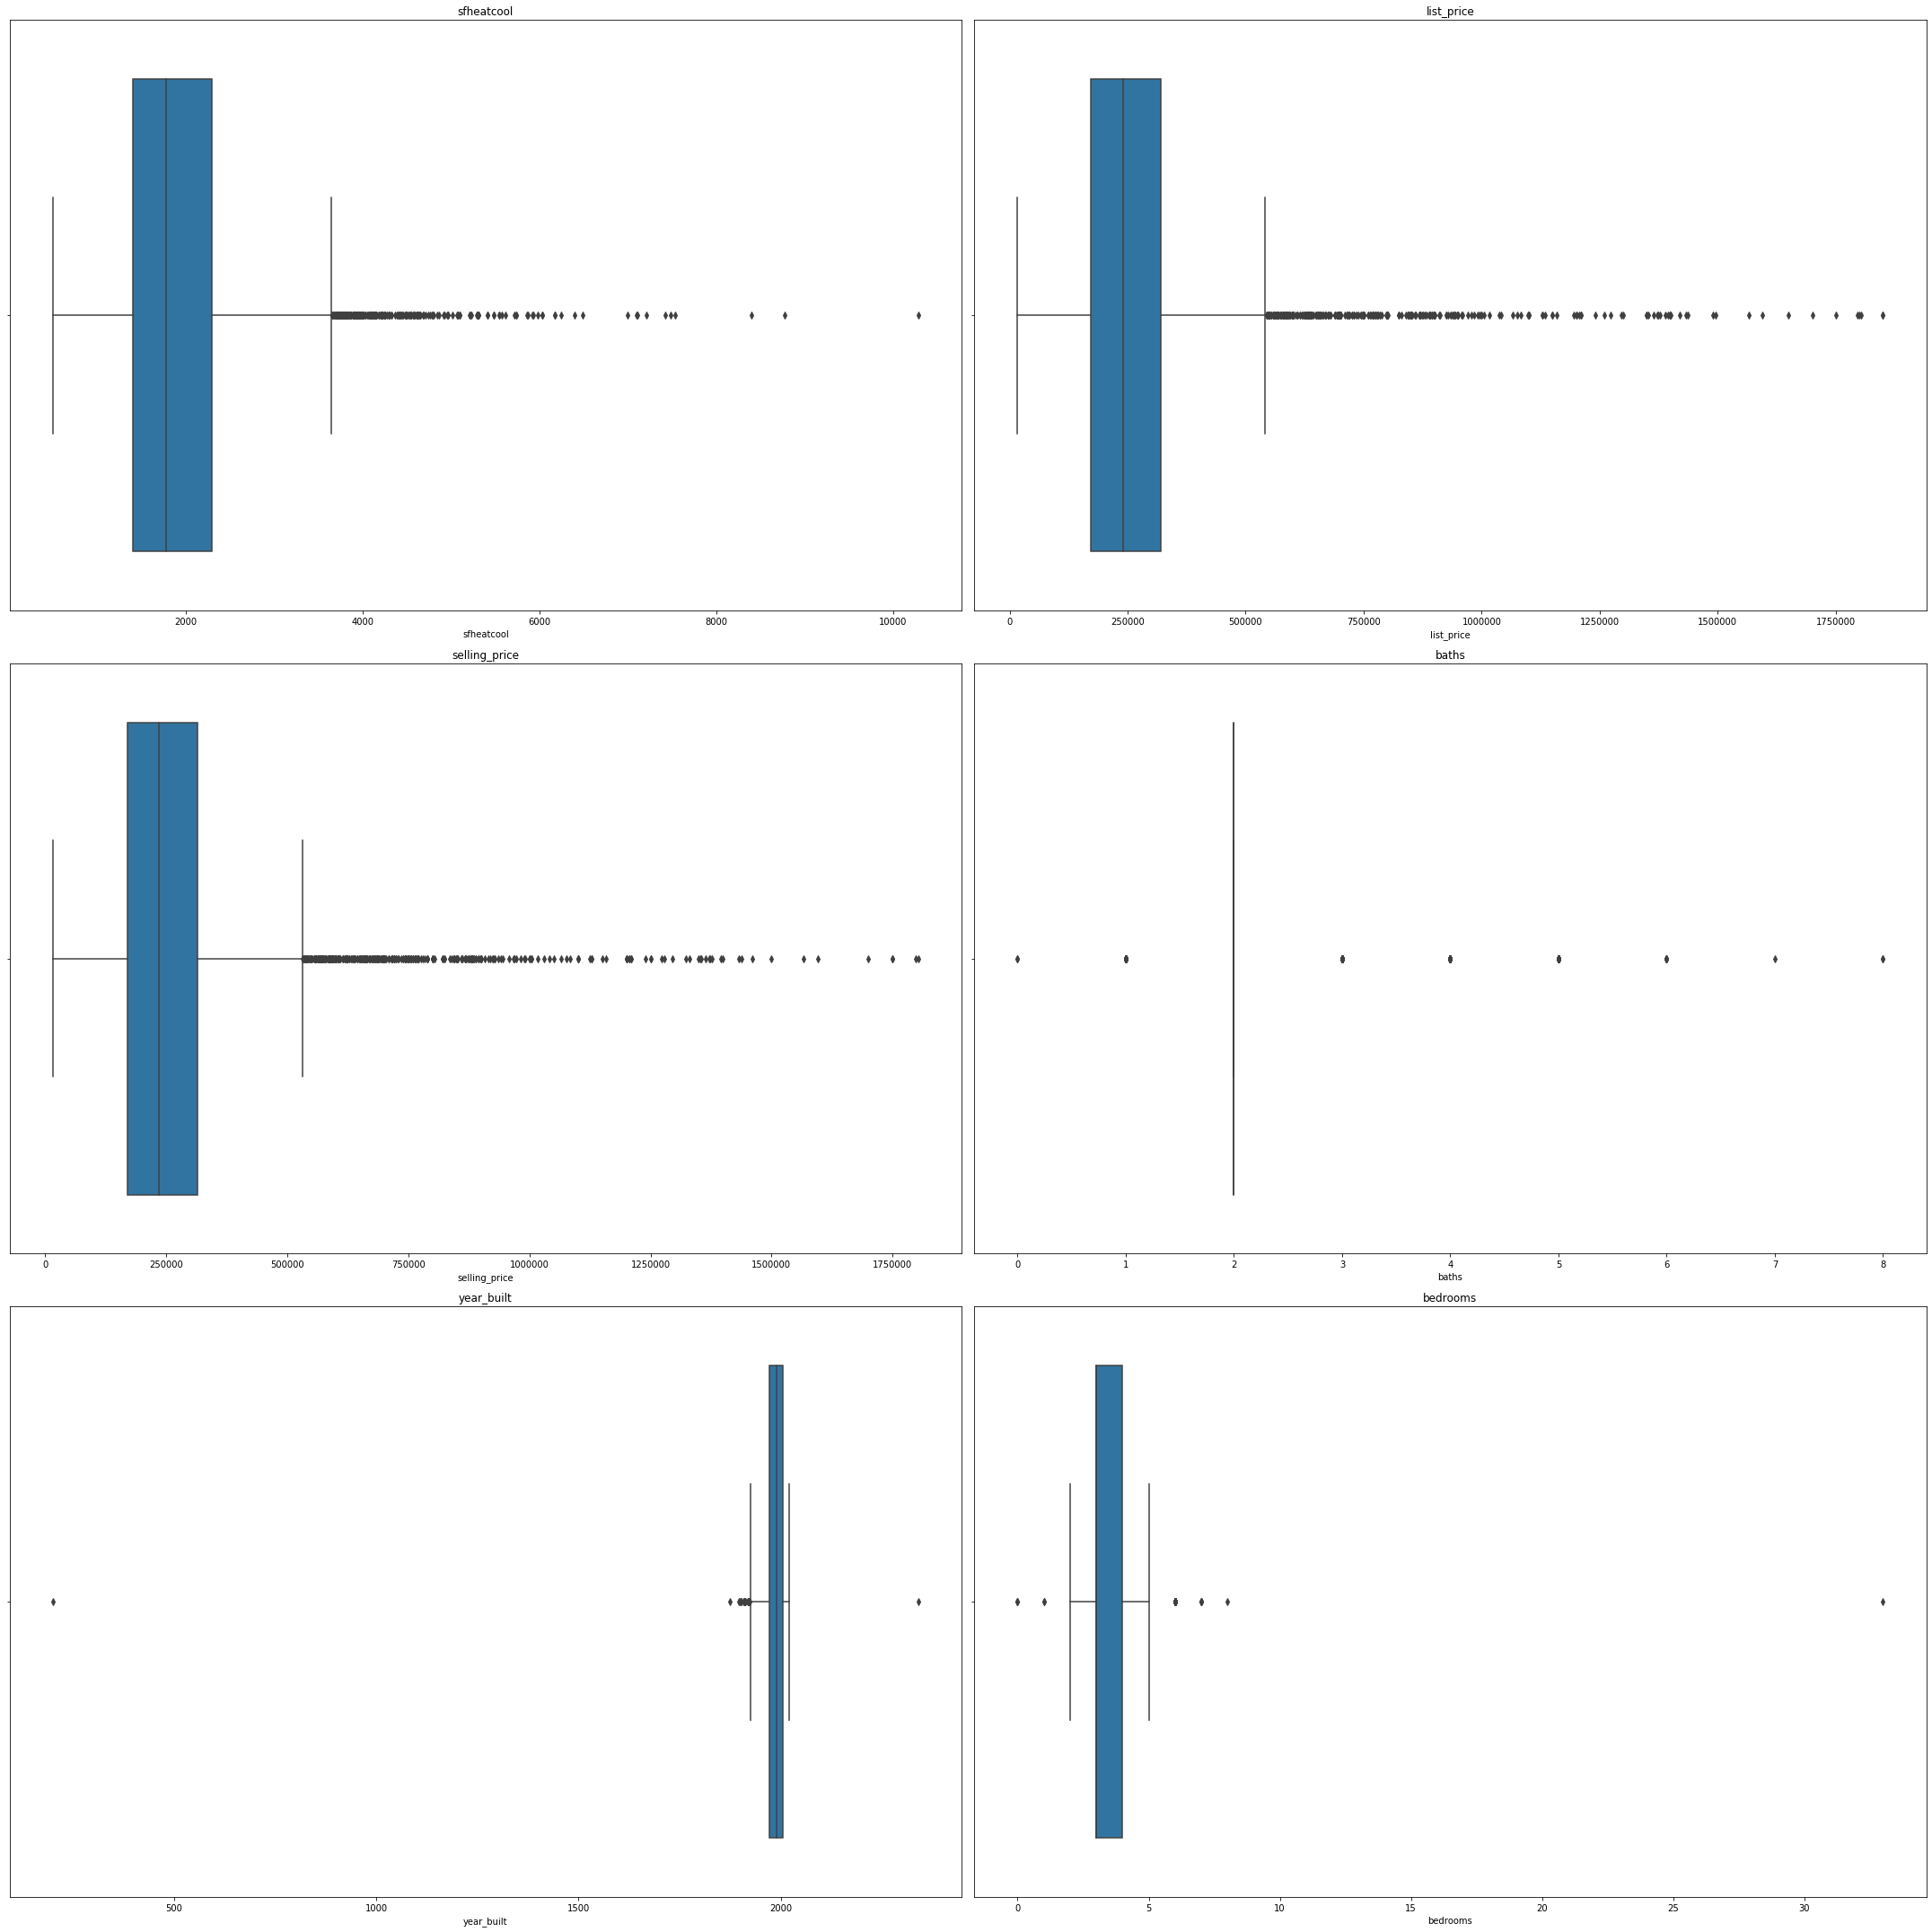

In [427]:
fig, axes = plt.subplots(3, 2, sharey=False)

sns.boxplot(real_estate['sfheatcool'], ax=axes[0, 0])
sns.boxplot(real_estate['list_price'], ax=axes[0, 1])
sns.boxplot(real_estate['selling_price'], ax=axes[1, 0])
sns.boxplot(real_estate['baths'], ax=axes[1, 1])
sns.boxplot(real_estate['year_built'], ax=axes[2, 0])
sns.boxplot(real_estate['bedrooms'], ax=axes[2, 1])

axes[0, 0].set_title('sfheatcool')
axes[0, 1].set_title('list_price')
axes[1, 0].set_title('selling_price')
axes[1, 1].set_title('baths')
axes[2, 0].set_title('year_built')
axes[2, 1].set_title('bedrooms')
                         
fig.set_size_inches(30, 30)
fig.tight_layout()

From these boxplots there are some pretty clear outliers I want to explore in each category.

#### Year Built

The year built are obvious user input errors, however accurately guessing what year should be there is impossible. Luckily I can double check user input errors using parcel ID via https://www.acpafl.org/searches/property-search/parcel-number-search/. The correct years have been input below.

In [428]:
real_estate[((real_estate['year_built'] > 2020) | (real_estate['year_built'] < 1800))].head()

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
3367,07054-202-175,235000,227166.0,126,130.05,125.71,CONVENTIONAL,32608,1807,201,2,4,0,Other,2.0,Yes,No,Shingle,Foundation-Slab Frame,Hardiboard/Concr Siding,Sink - Dual,Alarm System Compactor Cooktop - Gas Dishwashe...,Wood,Other,Craftsman,Carpet Tile Wood - Laminate,Great Room,Cash Conventional FHA USDA VA,Cul-de-sac,0.28,Sink - Dual,Cul-de-sac,Cash Conventional FHA USDA VA,Great Room,Carpet Tile Wood - Laminate,Craftsman,Other,Wood,Multiple,Hardiboard/Concr Siding,Foundation-Slab Frame,Shingle
5545,06849-002-006,354000,340000.0,82,151.28,145.30,OTHER,32608,2340,2340,2,4,1,Other,2.0,Yes,No,Shingle,Brick Foundation-Slab,Wood,Separate Tub- Jetted Walk-In Shower,Dishwasher Disposal Microwave Oven - Wall Refr...,Wood,Other,Traditional,Carpet Tile Wood - Hardwood,Family Room,Conventional FHA VA,Other,1.00,Multiple,Other,Multiple,Family Room,Carpet Tile Wood - Hardwood,Traditional,Other,Wood,Multiple,Wood,Multiple,Shingle


In [429]:
real_estate.loc[real_estate['year_built'].eq(895), 'year_built'] = 1998

real_estate.loc[real_estate['year_built'].eq(201), 'year_built'] = 2001

real_estate.loc[real_estate['parcel_number'].eq('06849-002-006'), 'year_built'] = 1973

#### Bedrooms

In [430]:
real_estate[(real_estate['bedrooms'] > 10) | (real_estate['bedrooms'] == 0)].head(10)

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
32,11276-001-000,30000,30000.0,28,22.12,22.12,CASH,32641,1356,1946,1,0,0,Other,0.0,No,No,Metal,Other,Wood Other,Single Vanity,None,Other None,Other,Other,Other,Other,Cash,Corner Lot Mostly Cleared/Grass Other,0.45,Single Vanity,Multiple,Cash,Other,Other,Other,Other,Multiple,None,Multiple,Other,Metal
34,07882-012-000,34900,31000.0,148,69.80,62.00,CASH,32653,500,1900,0,0,0,Other,0.0,No,No,Other,Other,Other,None,None,None,None,Other,None,None,Cash Sold As Is Title Ins Provided,Mostly Cleared/Grass Pasture on Property Recta...,0.26,None,Multiple,Multiple,Multiple,Multiple,Other,None,None,None,Other,Other,Other
131,14346-000-000,54900,54900.0,17,55.79,55.79,CASH,32601,984,1930,0,0,0,Handyman Special,0.0,No,No,Metal,Frame,Wood,None,None,Partial,Storage Shed,Craftsman,Other,None,Other,Rectangular-shaped,0.20,None,Rectangular-shaped,Other,Multiple,Other,Craftsman,Storage Shed,Partial,None,Wood,Frame,Metal
4053,06463-009-000,259900,253000.0,96,136.79,133.16,CASH,32607,1900,1958,2,33,0,Other,1.0,Yes,No,Shingle,Concrete Block,Deco Brick/Stone Concrete Block,None,None,Other,Other,Colonial,Other,Other,Other,Other,0.33,None,Other,Other,Other,Other,Multiple,Other,Other,None,Multiple,Concrete Block,Shingle


Interesting! 0 bedrooms can be interpreted as a tinyhome. However, I will inpute those as having 1 bedroom just to match other inputs. 33 bedrooms looks like an anomaly, so I decided to double check the parcel id on https://www.acpafl.org/searches/property-search/parcel-number-search/ and discovered that it should be 3 bedrooms.

In [431]:
real_estate.loc[real_estate['bedrooms'].eq(0), 'bedrooms'] = 1

real_estate.loc[real_estate['parcel_number'].eq('06463-009-000'), 'bedrooms'] = 3

#### Bathrooms

Parcel ID '04427-111-333' shows up as vacant land in the county database. Since the data input can't be confirmed, it will be dropped. I'm also going to drop the parcel ids ['16239-006-000','07882-012-000', '06029-008-000'] as there are a number of incorrect inputs for those property.

In [432]:
real_estate[((real_estate['baths'] > 6) | (real_estate['baths'] < 1))].head(10)

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
34,07882-012-000,34900,31000.0,148,69.80,62.00,CASH,32653,500,1900,0,1,0,Other,0.0,No,No,Other,Other,Other,None,None,None,None,Other,None,None,Cash Sold As Is Title Ins Provided,Mostly Cleared/Grass Pasture on Property Recta...,0.26,None,Multiple,Multiple,Multiple,Multiple,Other,None,None,None,Other,Other,Other
131,14346-000-000,54900,54900.0,17,55.79,55.79,CASH,32601,984,1930,0,1,0,Handyman Special,0.0,No,No,Metal,Frame,Wood,None,None,Partial,Storage Shed,Craftsman,Other,None,Other,Rectangular-shaped,0.20,None,Rectangular-shaped,Other,Multiple,Other,Craftsman,Storage Shed,Partial,None,Wood,Frame,Metal
4219,16239-006-000,269000,260000.0,144,70.05,67.71,CASH,32641,3840,1900,8,8,0,Other,0.0,No,No,Metal,Frame Metal/Steel,Wood,Single Vanity,Cooktop - Electric Dryer Microwave Oven - Elec...,None,None,Cottage,Carpet Tile Wood - Hardwood,Living Room Master Downstairs,Cash Conventional Sold As Is,Irregular Wooded Lot,5.00,Single Vanity,Multiple,Cash Conventional Sold As Is,Multiple,Carpet Tile Wood - Hardwood,Multiple,None,None,Multiple,Wood,Multiple,Metal
6772,06029-008-000,858000,765000.0,80,144.61,128.94,CONVENTIONAL,32653,5933,2001,7,6,2,Other,3.0,Yes,Yes,Shingle,Concrete Block Foundation-Slab,Conventional Stucco Concrete Block,Exhaust Fan Linen Closet in Bath Separate Tub-...,Alarm System Cooktop - Gas Dishwasher Disposal...,Chain Link Partial Wood Other,None,2 Story Contemporary,Carpet Tile Wood - Hardwood,2nd Kitchen Den/Ofc (Not Inc in Bd #) Family R...,Cash Conventional Other,Irregular Rectangular-shaped,2.60,Multiple,Multiple,Multiple,Multiple,Carpet Tile Wood - Hardwood,2 Story Contemporary,None,Multiple,Multiple,Multiple,Concrete Block Foundation-Slab,Shingle
6906,04427-111-333,1796929,1796929.0,26,240.01,240.01,CONVENTIONAL,32608,7487,2018,8,7,0,New Construction,3.0,Yes,Yes,Shingle,Frame,Synthetic Stucco/EIFS,Built-In Shower Bench Exhaust Fan Jack & Jill ...,Alarm System Cooktop - Gas Dishwasher Disposal...,None,None,2 Story Contemporary,Carpet Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Cash Conventional,Wooded Lot Sidewalks Pie-shaped,1.30,Multiple,Multiple,Cash Conventional,Multiple,Carpet Tile Wood - Hardwood,2 Story Contemporary,None,None,Multiple,Synthetic Stucco/EIFS,Frame,Shingle


In [433]:
real_estate.loc[real_estate['parcel_number'].eq('14346-000-000'), 'baths'] = 1

real_estate = real_estate.loc[~real_estate['parcel_number'].isin(['04427-111-333','16239-006-000','07882-012-000', '06029-008-000']), :]

#### Half Baths

Both these parcels will be dropped as there are too many input errors when compared with the county records

In [434]:
real_estate[(real_estate['half-baths'] > 2)].head()

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
6847,06860-346-013,1100000,983000.0,92,176.00,157.28,CASH,32608,6250,2006,4,5,3,Other,4.0,Yes,Yes,Shingle,Frame,Conventional Stucco,Built-In Shower Bench Exhaust Fan Jack & Jill ...,Alarm System Cooktop - Electric Dishwasher Dis...,Electric,Workshop,2 Story Traditional,Stone Tile Wood - Hardwood,2nd Kitchen Bonus (Not Inc in Bd #) Den/Ofc (N...,Cash Conventional Title Ins Provided,Square-shaped Wooded Lot,0.61,Multiple,Multiple,Cash Conventional Title Ins Provided,Multiple,Multiple,Multiple,Workshop,Multiple,Multiple,Conventional Stucco,Frame,Shingle
6889,06440-004-000,1595000,1355000.0,55,224.43,190.66,CASH,32607,7107,1951,6,7,3,Other,3.0,Yes,Yes,Shingle,Foundation-Slab Frame,Deco Brick/Stone Wood,Claw Foot Tub Exhaust Fan Sink - Dual Water Cl...,Alarm System Cooktop - Gas Dishwasher Disposal...,Partial PVC,Other,Colonial Split-Level,No Carpeting Tile Wood - Hardwood,2nd Kitchen Family Room Foyer In-Law Suite Lau...,Cash Conventional,Wooded Lot,3.20,Multiple,Wooded Lot,Cash Conventional,Multiple,No Carpeting Tile Wood - Hardwood,Multiple,Other,Multiple,Multiple,Multiple,Foundation-Slab Frame,Shingle


In [435]:
real_estate = real_estate.loc[~real_estate['parcel_number'].isin(['06440-004-000','06860-346-013']), :]

#### Square Feet

These values look to be correct, but do represent many of the outliers in other categories. Since these only represet 16 sales, I will drop these values for the sake of efficiency.

In [436]:
real_estate[(real_estate['sfheatcool'] > 6000)].head(20)

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
6741,06415-003-001,725000,725000.0,611,117.33,117.33,CONVENTIONAL,32605,6179,1992,3,4,1,Other,2.0,Yes,Yes,Shingle,Frame,Deco Brick/Stone,Separate Tub- Garden Split Vanities Walk-In Sh...,Alarm System Cooktop - Gas Dishwasher Disposal...,None,Storage Shed,2 Story Contemporary,Carpet Tile Wood - Hardwood,2nd Kitchen Den/Ofc (Not Inc in Bd #) Family R...,Other,Pasture on Property Wooded Lot,4.95,Multiple,Multiple,Other,Multiple,Carpet Tile Wood - Hardwood,2 Story Contemporary,Storage Shed,None,Multiple,Deco Brick/Stone,Frame,Shingle
6791,04322-020-005,879900,820000.0,88,135.47,126.25,CONVENTIONAL,32607,6495,1992,4,5,1,Other,3.0,Yes,Yes,Shingle,Brick Frame,Brick Veneer,Exhaust Fan Walk-In Shower,Alarm System Cooktop - Electric Dishwasher Dis...,Board (Horse),Bathroom Storage Shed Other,Contemporary,Carpet Tile Wood - Laminate,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Cash Conventional,Wooded Lot,2.00,Multiple,Wooded Lot,Cash Conventional,Multiple,Carpet Tile Wood - Laminate,Contemporary,Multiple,Multiple,Multiple,Brick Veneer,Multiple,Shingle
6827,07071-031-000,948000,895000.0,344,148.03,139.76,CONVENTIONAL,32608,6404,2003,4,5,2,Other,3.0,Yes,Yes,Shingle,Brick Frame,Brick Veneer,Linen Closet in Bath Makeup/Vanity Space Separ...,Alarm System Cooktop - Gas Dishwasher Disposal...,Wood Other,1-5 Stall Barn(s) Water Workshop Other,2 Story Traditional,Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Cash Conventional Title Ins Provided VA,Pasture on Property Rectangular-shaped Wooded Lot,10.00,Multiple,Multiple,Multiple,Multiple,Tile Wood - Hardwood,Multiple,Multiple,Multiple,Multiple,Brick Veneer,Multiple,Shingle
6858,04427010009,1134000,1050000.0,210,187.87,173.96,OTHER,32608,6036,2003,5,4,1,Other,3.0,Yes,Yes,Shingle,Concrete Block,Conventional Stucco,Linen Closet in Bath Separate Tub- Jetted Sink...,Alarm System Cooktop - Gas Dishwasher Disposal...,Other,Other,2 Story Colonial,Carpet Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Family Room Foyer La...,Cash Conventional Title Ins Provided,Cul-de-sac Rectangular-shaped Wooded Lot,1.90,Multiple,Multiple,Cash Conventional Title Ins Provided,Multiple,Carpet Tile Wood - Hardwood,Multiple,Other,Other,Multiple,Conventional Stucco,Concrete Block,Shingle
6869,06860-361-004,1149000,1150000.0,83,152.47,152.60,CONVENTIONAL,32608,7536,2002,6,7,2,Other,3.0,Yes,Yes,Shingle,Other,Hardiboard/Concr Siding,Bidet Built-In Shower Bench Jack & Jill Bath L...,Alarm System Cooktop - Gas Dishwasher Disposal...,Wood,Other,2 Story Traditional,Carpet Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Family Room Foyer Gr...,Cash Conventional FHA Other USDA VA,Cul-de-sac Pie-shaped,2.10,Multiple,Multiple,Multiple,Multiple,Carpet Tile Wood - Hardwood,Multiple,Other,Wood,Multiple,Hardiboard/Concr Siding,Other,Shingle
6879,07354-024-000,1400000,1240000.0,141,226.61,200.71,CONVENTIONAL,32608,6178,2000,4,5,2,Other,3.0,Yes,Yes,Shingle,Concrete Block,Conventional Stucco,Bidet Exhaust Fan Jack & Jill Bath Linen Close...,Alarm System Cooktop - Gas Dishwasher Disposal...,Board (Horse) Complete Perimeter Wood,5+ Stall Barns Bathroom Center Aisle Barn Tack...,2 Story Mediterranean,Carpet Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Cash Conventional,Pasture on Property Rectangular-shaped,55.59,Multiple,Multiple,Cash Conventional,Mult

In [437]:
real_estate = real_estate[~(real_estate['sfheatcool'] > 6000)]

#### List Price

I wanted to do some exploring with list price, but through iterative EDA and model runs I discovered that list price is too predictive of sales price and end up dropping it before running my final model.

In [438]:
real_estate[(real_estate['list_price'] > 1400000)].head(10)

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
6832,06039-001-000,1650000,907030.0,1174,347.81,191.20,SELLER,32606,4744,1972,3,5,1,Other,2.0,Yes,Yes,Metal,Frame,Deco Brick/Stone,Sink - Dual,Alarm System Cooktop - Electric Dishwasher Dry...,Barbed Wire Complete Perimeter Mixed Type,Pole Barn,Ranch,Carpet Tile,Den/Ofc (Not Inc in Bd #) Family Room Foyer La...,Cash,Pasture on Property Wooded Lot,86.00,Sink - Dual,Multiple,Cash,Multiple,Carpet Tile,Ranch,Multiple,Multiple,Multiple,Deco Brick/Stone,Frame,Metal
6886,06035-015-007,1490000,1330000.0,200,292.16,260.78,CONVENTIONAL,32653,5100,1982,4,4,2,Other,4.0,Yes,Yes,Metal,Frame,T-111 Other,Built-In Shower Bench Exhaust Fan Multiple Sho...,Cooktop - Gas Dishwasher Disposal Dryer Freeze...,Mixed Type,Other,Contemporary Modern Split-Level,Concrete - Finished Marble Tile Wood - Hardwood,2nd Kitchen Family Room Foyer In-Law Suite Lau...,Cash Conventional,Rectangular-shaped Wooded Lot,10.00,Multiple,Rectangular-shaped Wooded Lot,Cash Conventional,Multiple,Multiple,Multiple,Other,Mixed Type,Multiple,Multiple,Frame,Metal
6897,04427-111-099,1433000,1433000.0,0,288.33,288.33,CONVENTIONAL,32608,4970,2017,5,6,0,New Construction,3.0,Yes,Yes,Shingle,Foundation-Slab Frame,Deco Brick/Stone Hardiboard/Concr Siding,Built-In Shower Bench Linen Closet in Bath Rai...,Cooktop - Gas Dishwasher Disposal Microwave,None,None,2 Story Contemporary,Carpet Tile Vinyl Wood - Hardwood,Bonus (Not Inc in Bd #) Family Room Foyer Laun...,Other,Wooded Lot Sidewalks,1.00,Multiple,Multiple,Other,Multiple,Multiple,2 Story Contemporary,None,None,Multiple,Deco Brick/Stone Hardiboard/Concr Siding,Foundation-Slab Frame,Shingle
6898,04427-111-109,1437250,1437250.0,0,259.10,259.10,CASH,32608,5547,2017,5,4,1,New Construction,3.0,Yes,Yes,Shingle,Frame,Brick Veneer Conventional Stucco,Jack & Jill Bath Linen Closet in Bath Makeup/V...,Alarm System Cooktop - Gas Dishwasher Disposal...,Wood,None,2 Story Traditional,Carpet Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Family Room Foyer In...,Other,Rectangular-shaped Wooded Lot Sidewalks,1.00,Multiple,Multiple,Other,Multiple,Carpet Tile Wood - Hardwood,Multiple,None,Wood,Multiple,Multiple,Frame,Shingle
6899,04427-111-102,1419500,1460000.0,427,306.85,315.61,CASH,32608,4626,2017,5,4,1,New Construction,3.0,Yes,Yes,Shingle,Frame,Conventional Stucco,Built-In Shower Bench Linen Closet in Bath Mul...,Alarm System Cooktop - Gas Dishwasher Disposal...,Other,None,2 Story Contemporary,Carpet Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Foyer Great Room In-...,Cash Conventional Title Ins Provided,Corner Lot Rectangular-shaped Wooded Lot Sidew...,1.00,Multiple,Multiple,Cash Conventional Title Ins Provided,Multiple,Carpet Tile Wood - Hardwood,2 Story Contemporary,None,Other,Multiple,Conventional Stucco,Frame,Shingle
6900,04427-111-332,1495000,1500000.0,357,293.02,294.00,CASH,32608,5102,2019,6,5,0,New Construction,3.0,Yes,Yes,Shingle,Foundation-Slab Frame,Hardiboard/Concr Siding Synthetic Stucco/EIFS,Built-In Shower Bench Exhaust Fan Multiple Sho...,Alarm System Cooktop - Gas Dishwasher Disposal...,None,None,2 Story,Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Family Room Laundry/...,Cash Conventional,Rectangular-shaped Wooded Lot Sidewalks,1.00,Multiple,Multiple,Cash Conventional,Multiple,Tile Wood - Hardwood,2 Story,None,None,Multiple,Multiple,Foundation-Slab Frame,Shingle
6901,04427-111-108,1565759,

#### Sale Price

An early dive into my target variable shows some really interesting findings! Most houses over $1 million are under construction or are new constructions. The 9 properties that are not are likely custom homes constructed by famous architects. 

I may revisit this portion of data to winsorize the 15 properties that sold for over $1.3 million if that proves to be disruptive to my model. However, this information has value and I hesitate to drop the outliers.

In [439]:
real_estate[(real_estate['selling_price'] > 1000000)].head(50).sort_values(by = 'condition', ascending = False)

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
6867,04427-111-103,1128235,1128235.0,2,266.72,266.72,CONVENTIONAL,32608,4230,2018,4,4,1,Under Construction,3.0,Yes,Yes,Shingle,Frame,Deco Brick/Stone Synthetic Stucco/EIFS,Built-In Shower Bench Jack & Jill Bath Linen C...,Alarm System Cooktop - Electric Dishwasher Dis...,None,None,Contemporary,Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Conventional,Rectangular-shaped,1.00,Multiple,Rectangular-shaped,Multiple,Multiple,Tile Wood - Hardwood,Contemporary,None,None,Multiple,Multiple,Frame,Shingle
6888,044277-111-403,1353037,1353037.0,23,344.72,344.72,CONVENTIONAL,32608,3925,2019,3,4,2,Under Construction,3.0,Yes,Yes,Shingle,Foundation-Slab Frame,Synthetic Stucco/EIFS,Exhaust Fan Jack & Jill Bath Linen Closet in B...,Alarm System Cooktop - Gas Dishwasher Disposal...,Other,None,Mediterranean,Carpet Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Foyer Great Room Lau...,Cash Conventional Title Ins Not Provided,Corner Lot Rectangular-shaped Wooded Lot Sidew...,1.00,Multiple,Multiple,Multiple,Multiple,Carpet Tile Wood - Hardwood,Multiple,None,Other,Multiple,Synthetic Stucco/EIFS,Foundation-Slab Frame,Shingle
6876,06303-050-011,1209976,1209976.0,46,270.99,270.99,CONVENTIONAL,32606,4465,2019,3,4,2,Under Construction,3.0,Yes,Yes,Shingle,Foundation-Slab Frame,Conventional Stucco,Built-In Shower Bench Exhaust Fan Jack & Jill ...,Alarm System Cooktop - Gas Dishwasher Disposal...,Partial,None,Contemporary Modern,Carpet Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Cash Conventional Title Ins Not Provided,Irregular Pie-shaped,1.00,Multiple,Multiple,Multiple,Multiple,Carpet Tile Wood - Hardwood,Multiple,None,Partial,Multiple,Conventional Stucco,Foundation-Slab Frame,Shingle
6860,04326-000-000,1076019,1076019.0,36,211.90,211.90,CONVENTIONAL,32608,5078,2018,5,6,0,Under Construction,3.0,Yes,No,Tile,Frame,Synthetic Stucco/EIFS,Built-In Shower Bench Linen Closet in Bath Mul...,Alarm System Cooktop - Gas Dishwasher Disposal...,None,None,2 Story Mediterranean,Carpet Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Conventional Title Ins Not Provided,Rectangular-shaped Wooded Lot,5.00,Multiple,Rectangular-shaped Wooded Lot,Multiple,Multiple,Carpet Tile Wood - Hardwood,Multiple,None,None,Multiple,Synthetic Stucco/EIFS,Frame,Tile
6870,04427-111-101,1158901,1158901.0,31,268.95,268.95,CASH,32608,4309,2019,4,4,2,Under Construction,3.0,Yes,No,Shingle,Frame,Conventional Stucco,Linen Closet in Bath Multiple Shower Heads Sep...,Alarm System Cooktop - Gas Dishwasher Microwav...,Other,None,Contemporary,Carpet Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Cash Conventional Title Ins Not Provided,Rectangular-shaped Wooded Lot Sidewalks,1.00,Multiple,Multiple,Multiple,Multiple,Carpet Tile Wood - Hardwood,Contemporary,None,Other,Multiple,Conventional Stucco,Frame,Shingle
6868,07247-020-006,1129019,1129019.0,72,249.73,249.73,CONVENTIONAL,32608,4521,2018,5,4,0,Under Construction,3.0,Yes,Yes,Shingle,Frame,Deco Brick/Stone Synthetic Stucco/EIFS,Built-In Shower Bench Linen Closet in Bath Mak...,Alarm System Cooktop - Gas Dishwasher Disposal...,None,None,2 Story,Carpet Tile Wood - Hardwood,Bonus (Not Inc in Bd #) Den/Ofc (Not Inc in Bd...,Conventional Title Ins Provided,Square-shaped,0.24,Multiple,Square-shaped,Multiple,Multiple,Carpet Til

#### Parcel size (acres)

In [440]:
real_estate[(real_estate['parcel_size_(acres)'] > 20)].head(50).sort_values(by = 'condition', ascending = False)

,parcel_number,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,how_sold_code,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n,roof,construction_type,exterior_finish,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),bathroom_features_truncated,lot_info_truncated,terms_truncated,interior_layout_truncated,floors_truncated,style_truncated,outbuilding_features_truncated,fencing_truncated,appliances/equipment_truncated,exterior_finish_truncated,construction_type_truncated,roof_truncated
3613,15136001000,239000,235000.0,51,165.06,162.29,CASH,32605,1448,1961,2,3,0,Other,0.0,No,No,Shingle,Concrete Block,Concrete Block,Single Vanity,Oven - Electric,None,None,Cottage,Wood - Hardwood,Great Room,May Exchange,Cul-de-sac,6848.00,Single Vanity,Cul-de-sac,Multiple,Great Room,Wood - Hardwood,Multiple,None,None,Multiple,Concrete Block,Concrete Block,Shingle
5863,05794-002-000,399900,375000.0,123,145.42,136.36,CONVENTIONAL,32609,2750,2004,2,3,1,Other,0.0,No,Yes,Metal,Concrete Block Frame,Other,Sink - Dual Tub/Shower Combo Walk-In Shower,Cooktop - Electric Dishwasher Dryer Microwave ...,Mixed Type Woven Wire,Pole Barn Storage Shed,2 Story Ranch,Carpet Tile Wood - Hardwood,Great Room Laundry/Utility Room Master Downsta...,Cash Title Ins Provided,Pasture on Property Wooded Lot,22.18,Multiple,Multiple,Multiple,Multiple,Carpet Tile Wood - Hardwood,Multiple,Multiple,Multiple,Multiple,Other,Multiple,Metal
6180,06672-200-101,429900,429900.0,76,155.14,155.14,CONVENTIONAL,32607,2771,2003,3,4,1,Other,2.0,Yes,No,Shingle,Frame,Conventional Stucco Hardiboard/Concr Siding,Exhaust Fan Separate Tub- Jetted Walk-In Showe...,Alarm System Dishwasher Disposal Microwave Ove...,Privacy Wood,Workshop,Contemporary,Carpet Tile,Den/Ofc (Not Inc in Bd #) Family Room Foyer Gr...,Title Ins Provided,Corner Lot,34.00,Multiple,Corner Lot,Title Ins Provided,Multiple,Carpet Tile,Contemporary,Workshop,Privacy Wood,Multiple,Multiple,Frame,Shingle
6487,07678-005-000,520000,520000.0,348,160.05,160.05,CASH,32609,3249,1981,4,5,2,Other,2.0,Yes,No,Shingle,Frame,Hardiboard/Concr Siding,Makeup/Vanity Space,Alarm System Dishwasher Dryer Oven - Electric ...,Wood,Power,2 Story Contemporary,Carpet Tile Wood - Hardwood,Den/Ofc (Not Inc in Bd #) Family Room Foyer La...,Title Ins Provided,Pasture on Property Wooded Lot,161.00,Multiple,Multiple,Title Ins Provided,Multiple,Carpet Tile Wood - Hardwood,2 Story Contemporary,Multiple,Wood,Multiple,Hardiboard/Concr Siding,Frame,Shingle
6832,06039-001-000,1650000,907030.0,1174,347.81,191.20,SELLER,32606,4744,1972,3,5,1,Other,2.0,Yes,Yes,Metal,Frame,Deco Brick/Stone,Sink - Dual,Alarm System Cooktop - Electric Dishwasher Dry...,Barbed Wire Complete Perimeter Mixed Type,Pole Barn,Ranch,Carpet Tile,Den/Ofc (Not Inc in Bd #) Family Room Foyer La...,Cash,Pasture on Property Wooded Lot,86.00,Sink - Dual,Multiple,Cash,Multiple,Carpet Tile,Ranch,Multiple,Multiple,Multiple,Deco Brick/Stone,Frame,Metal
6905,04308-000-000,1850000,1750000.0,866,1761.90,1666.67,CASH,32606,1050,1930,1,3,0,Other,0.0,No,No,Other,Frame,Other,Exhaust Fan,None,Mixed Type,None,Cracker,Other,Other,Cash,Pasture on Property,70.00,Exhaust Fan,Multiple,Cash,Other,Other,Multiple,None,Mixed Type,None,Other,Frame,Other
5835,05773-002-000,425000,372500.0,74,165.89,145.39,CASH,32653,2562,1974,3,4,0,Handyman Special,3.0,Yes,Yes,Other,Frame,Wood,Exhaust Fan Sink - Dual Tub/Shower Combo Walk-...,None,Barbed Wire Woven Wire,None,2 Story,Carpet Vinyl,Den/Ofc (Not Inc in Bd #) Family Room Great Ro...,Cash Conventional Other Sold As Is Title Ins P...,Irregular Mostly Cleared/Grass Pasture on Prop...,63.00,Multiple,Multiple,Multiple,Multiple,Carpet Vinyl,2 Story,None,Multiple,None,Wood,Frame,Other


In [441]:
real_estate = real_estate[~(real_estate['parcel_size_(acres)'] > 20)]

#### Revisiting the boxplot distributions

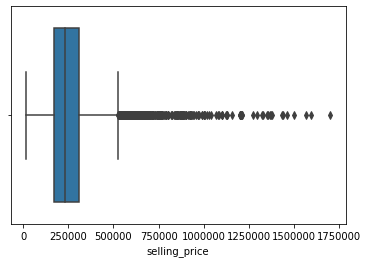

In [442]:
sns.boxplot(real_estate['selling_price'])
fig.savefig("saleprice.png")


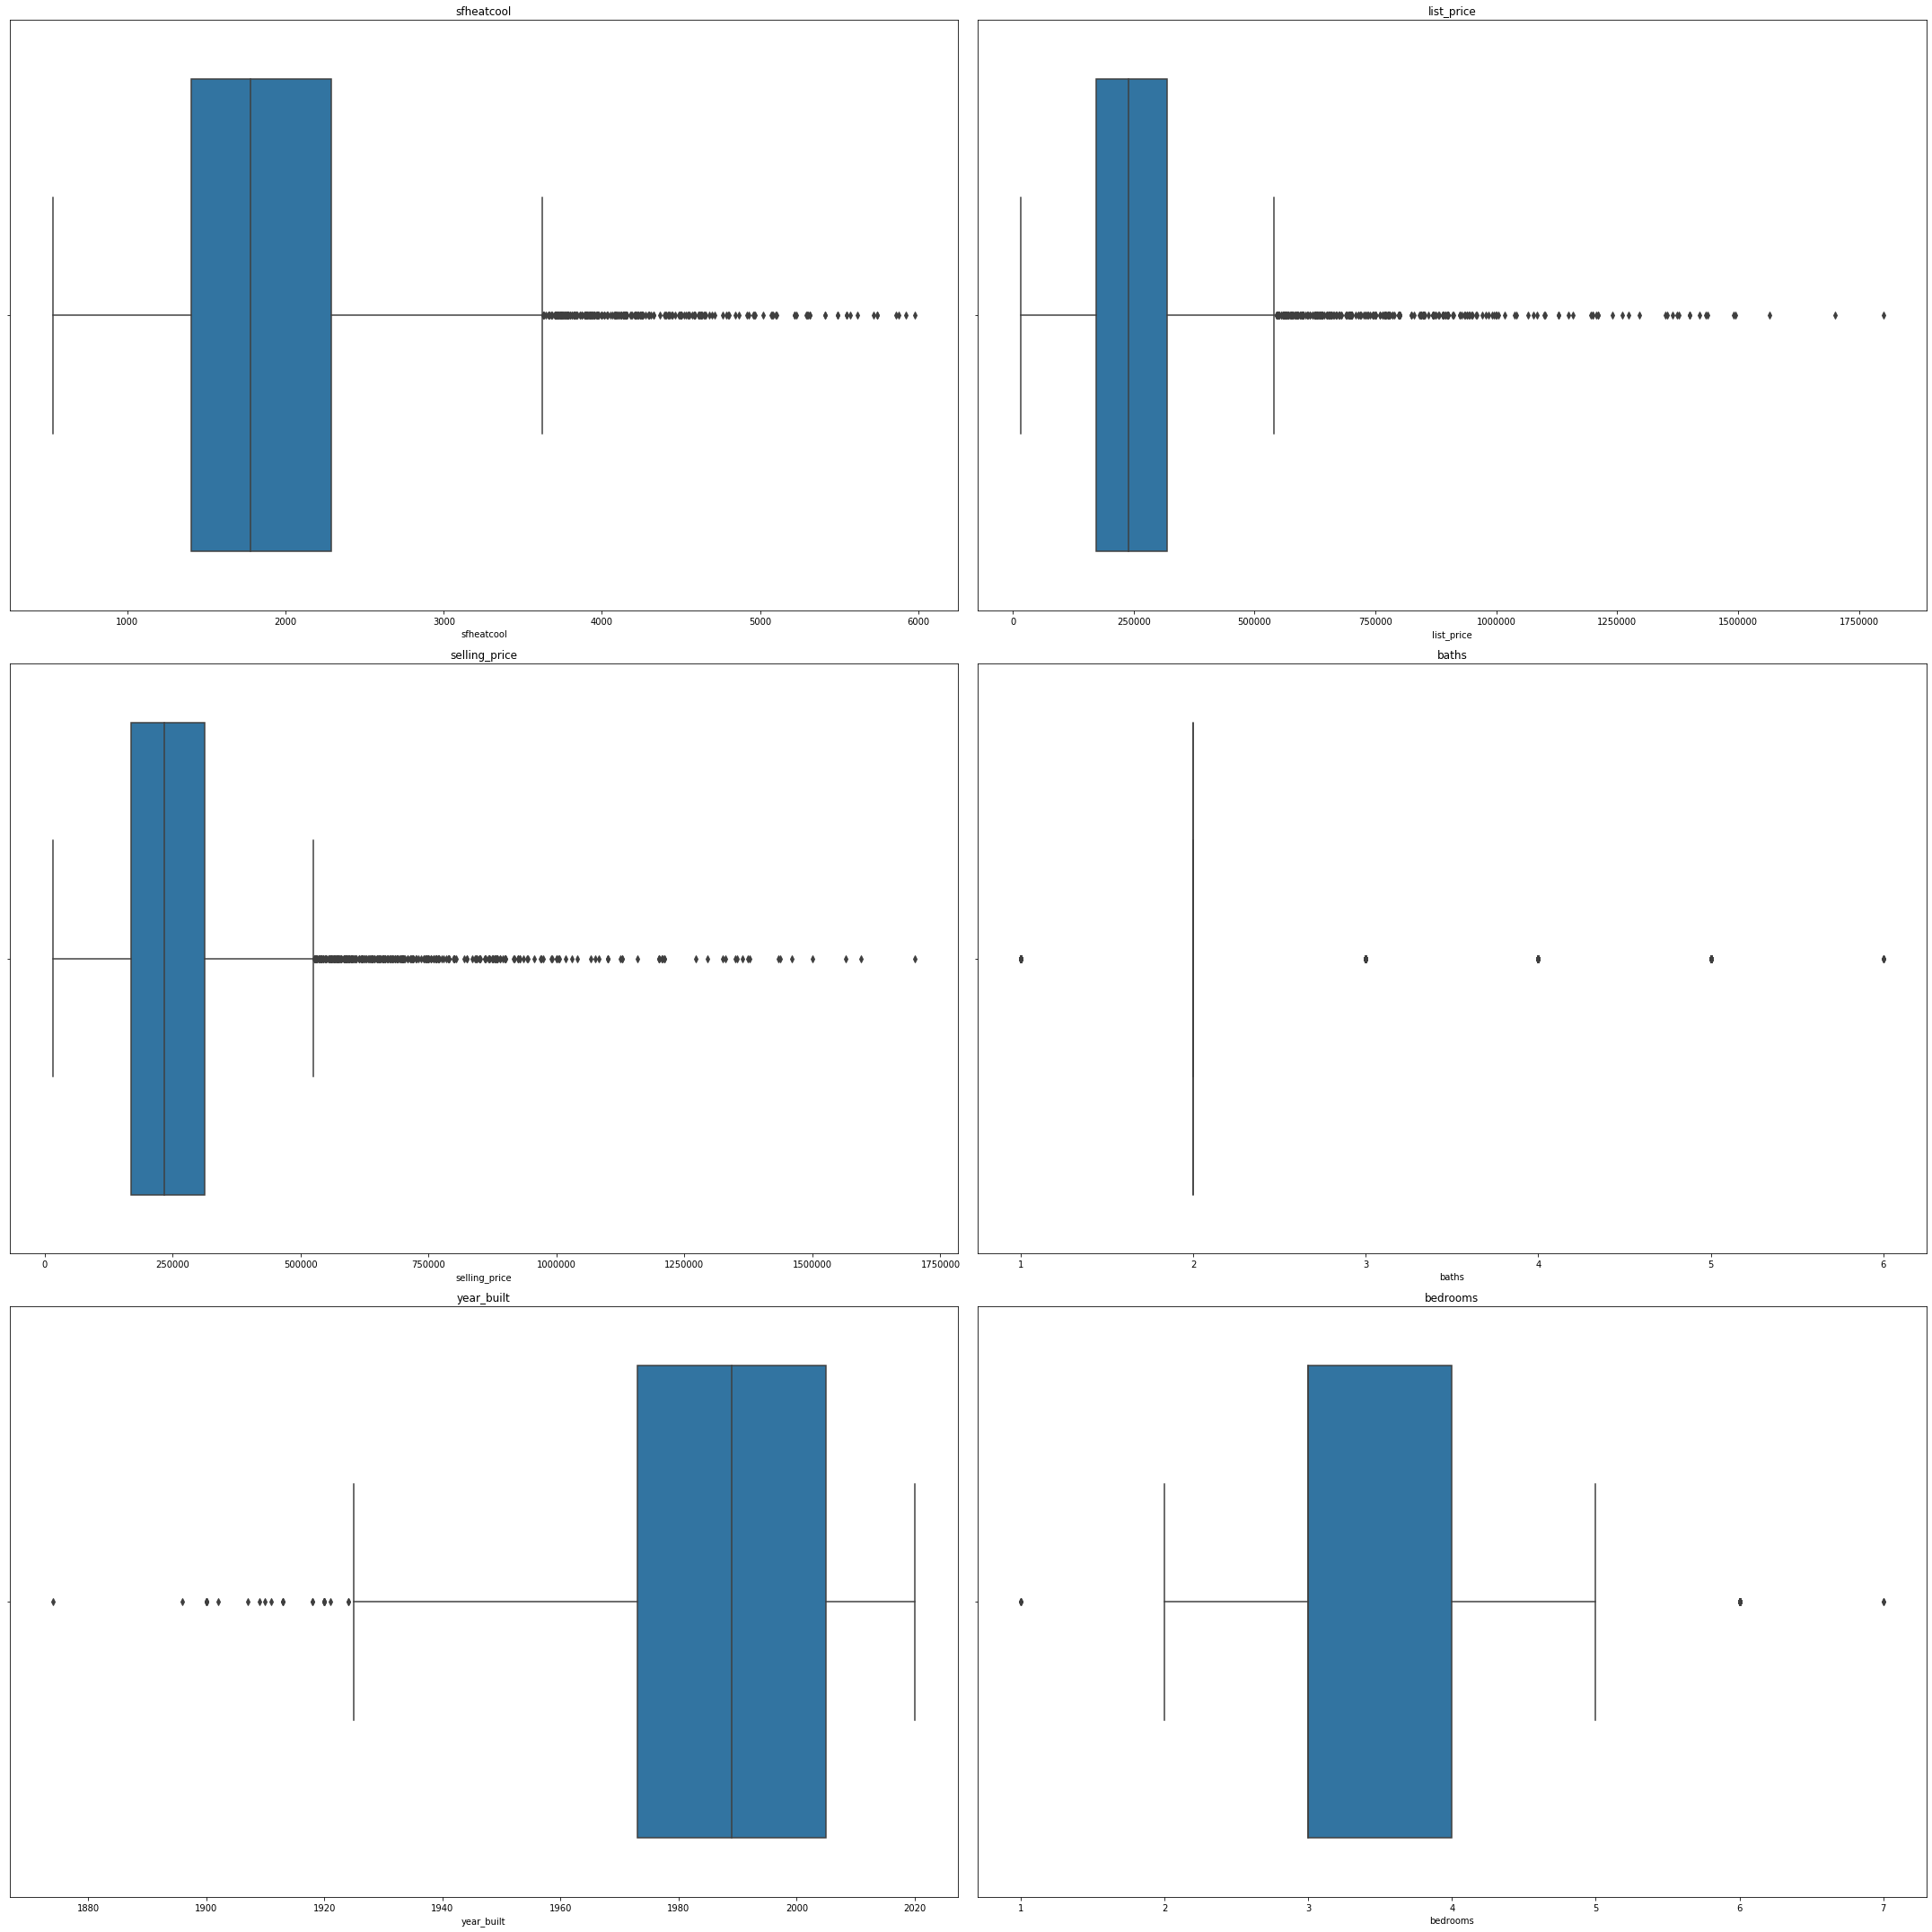

In [443]:
fig, axes = plt.subplots(3, 2, sharey=False)
                         
sns.boxplot(real_estate['sfheatcool'], ax=axes[0, 0])
sns.boxplot(real_estate['list_price'], ax=axes[0, 1])
sns.boxplot(real_estate['selling_price'], ax=axes[1, 0])
sns.boxplot(real_estate['baths'], ax=axes[1, 1])
sns.boxplot(real_estate['year_built'], ax=axes[2, 0])
sns.boxplot(real_estate['bedrooms'], ax=axes[2, 1])

axes[0, 0].set_title('sfheatcool')
axes[0, 1].set_title('list_price')
axes[1, 0].set_title('selling_price')
axes[1, 1].set_title('baths')
axes[2, 0].set_title('year_built')
axes[2, 1].set_title('bedrooms')

fig.set_size_inches(30, 30)
fig.tight_layout()

In [444]:
real_estate.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,list_price,selling_price,days_on_market,list_price_/_sqft,sold_price/sqft,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,#_of_garage_spaces,parcel_size_(acres)
count,6362,6362,6362,6362,6362,6362,6362,6362,6362,6362,6362,6362,6362
mean,272083,266103,101.77,135.569,132.646,32613.6,1938.8,1987.3,2.19742,3.35696,0.173059,1.49073,0.512094
std,162611,159594,100.855,34.8235,35.2273,16.3544,765.705,21.693,0.683081,0.718119,0.393402,0.950591,1.13976
min,17000,16000,0,11.77,11.77,32601,528,1874,1,1,0,0,0
25%,172000,169900,45,115.74,112.78,32606,1402,1973,2,3,0,1,0.19
50%,239900,234682,69,133.92,131.405,32608,1778.5,1989,2,3,0,2,0.25
75%,319900,312000,124.75,153.528,150.588,32608,2291.25,2005,2,4,0,2,0.4
max,1.8e+06,1.7e+06,2443,409.15,409.15,32653,5978,2020,6,7,2,4,20


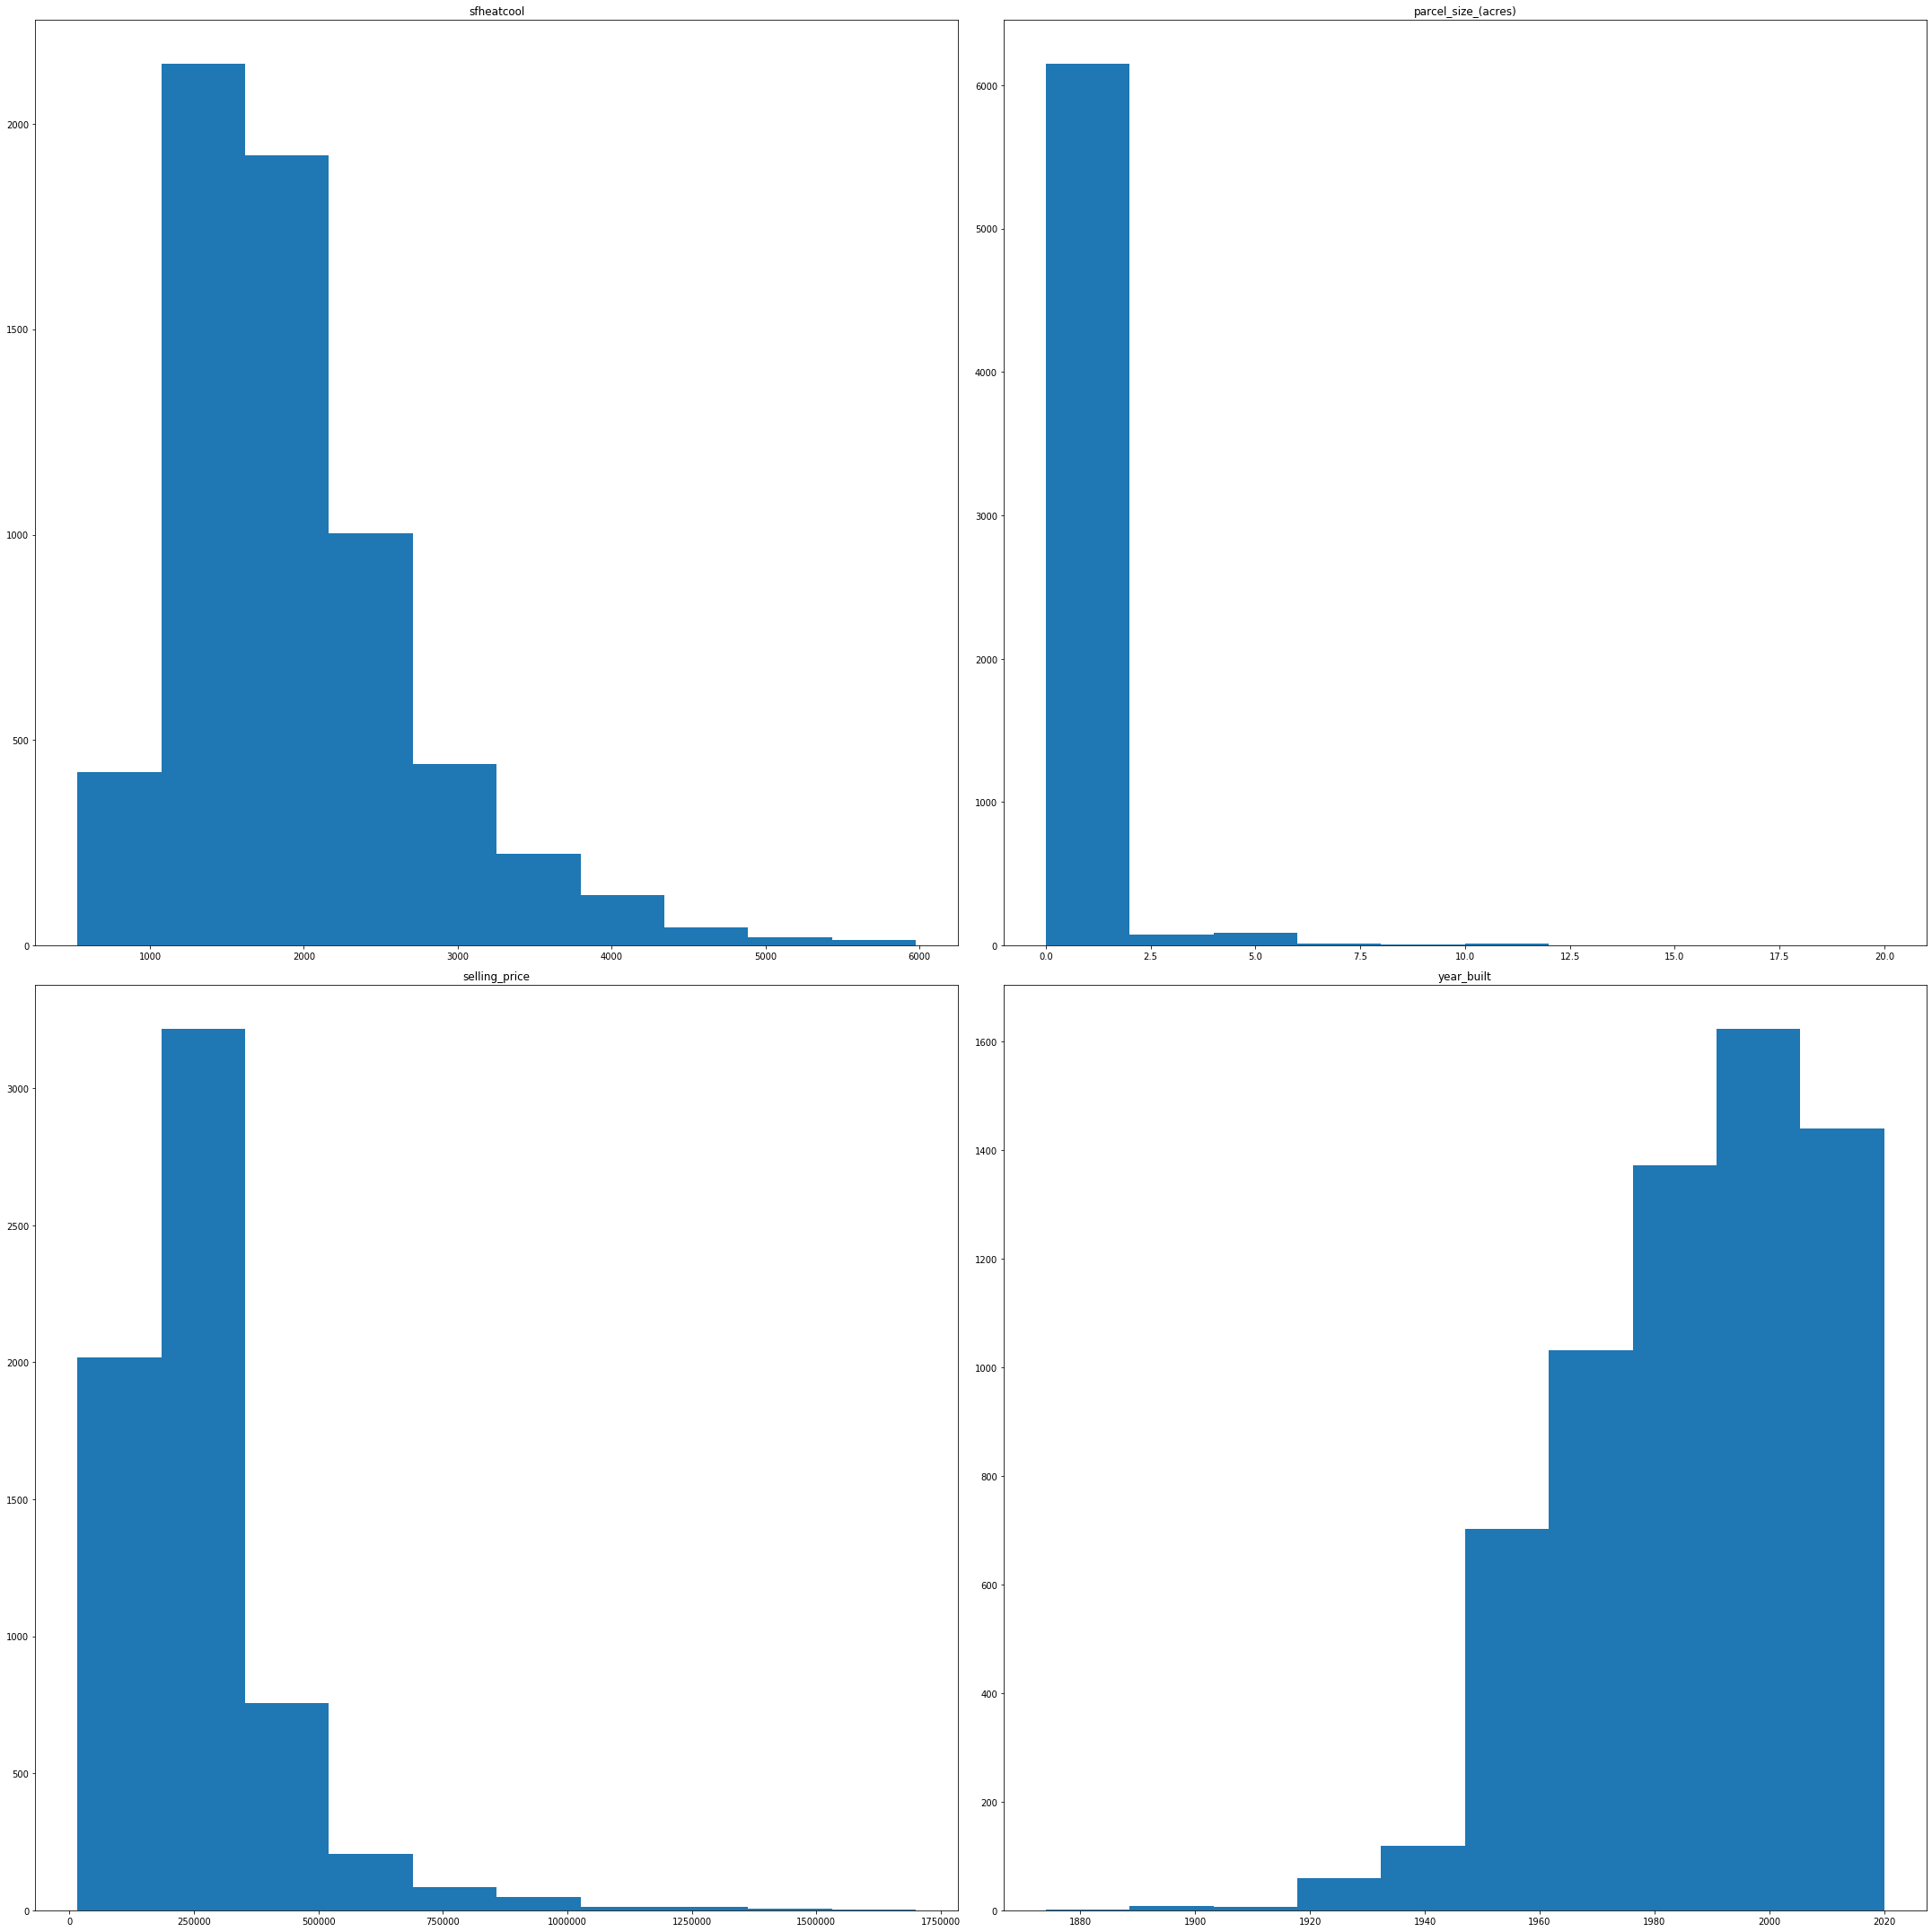

In [445]:
fig, axes = plt.subplots(2, 2, sharey=False)
                         
axes[0, 0].hist(real_estate['sfheatcool'])
axes[0, 1].hist(real_estate['parcel_size_(acres)'])
axes[1, 0].hist(real_estate['selling_price'])
axes[1, 1].hist(real_estate['year_built'])

axes[0, 0].set_title('sfheatcool')
axes[0, 1].set_title('parcel_size_(acres)')
axes[1, 0].set_title('selling_price')
axes[1, 1].set_title('year_built')
fig.savefig("histo.png")
                         
fig.set_size_inches(30, 30)
fig.tight_layout()

## Feature Engineering

In [446]:
features_df = real_estate.drop(columns = ['parcel_number'])

In [447]:
features_df.columns

Index(['list_price', 'selling_price', 'days_on_market', 'list_price_/_sqft',
       'sold_price/sqft', 'how_sold_code', 'zip_code', 'sfheatcool',
       'year_built', 'baths', 'bedrooms', 'half-baths', 'condition',
       '#_of_garage_spaces', 'garage_y/n', 'pool_y/n', 'roof',
       'construction_type', 'exterior_finish', 'bathroom_features',
       'appliances/equipment', 'fencing', 'outbuilding_features', 'style',
       'floors', 'interior_layout', 'terms', 'lot_info', 'parcel_size_(acres)',
       'bathroom_features_truncated', 'lot_info_truncated', 'terms_truncated',
       'interior_layout_truncated', 'floors_truncated', 'style_truncated',
       'outbuilding_features_truncated', 'fencing_truncated',
       'appliances/equipment_truncated', 'exterior_finish_truncated',
       'construction_type_truncated', 'roof_truncated'],
      dtype='object')

(13.0, 0.0)

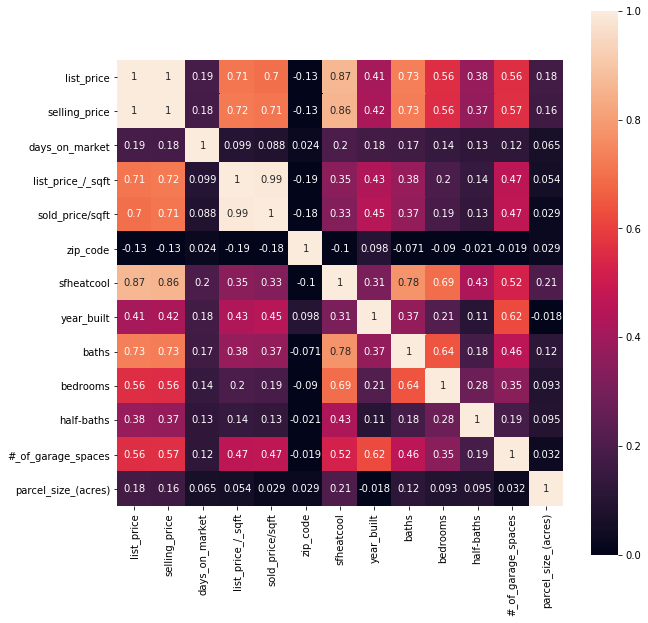

In [448]:
relationships = features_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(relationships, vmin = 0, vmax = 1, square = True, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

It appears there is some serious multicollinearity going on between list price and sales price. Here sales price is more valuable to me - and out of all the similar metrics, sold_price/sqft tells the clearest picture across all house types. It willbe the variable I keep.

In [449]:
features1_df = features_df.drop(columns = ['list_price', 'selling_price', 'list_price_/_sqft', 'garage_y/n', 'pool_y/n'])

(10.0, 0.0)

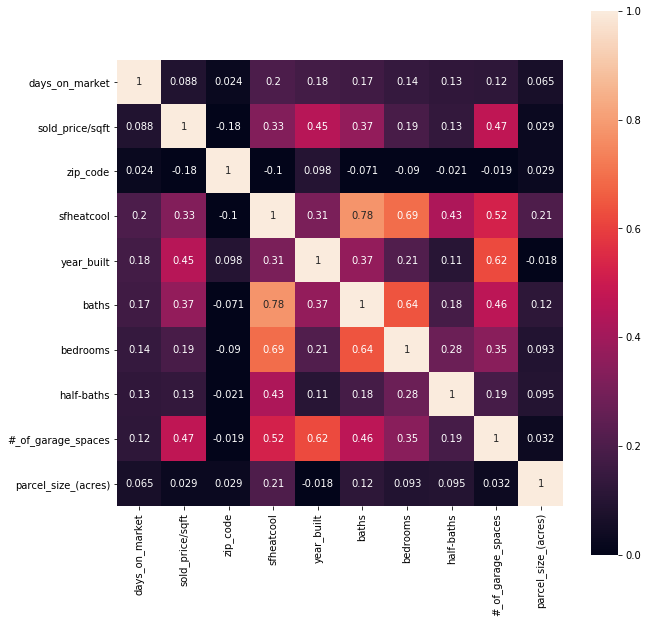

In [450]:
relationships = features1_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(relationships, vmin = 0, vmax = 1, square = True, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Dummie Split Function

Mentioned above, this function splits the features with multiple inputs on the string level.

I also iteratively dropped dining_area as a feature in my model as it was creating outlier results

In [451]:
features1_df.columns

Index(['days_on_market', 'sold_price/sqft', 'how_sold_code', 'zip_code',
       'sfheatcool', 'year_built', 'baths', 'bedrooms', 'half-baths',
       'condition', '#_of_garage_spaces', 'roof', 'construction_type',
       'exterior_finish', 'bathroom_features', 'appliances/equipment',
       'fencing', 'outbuilding_features', 'style', 'floors', 'interior_layout',
       'terms', 'lot_info', 'parcel_size_(acres)',
       'bathroom_features_truncated', 'lot_info_truncated', 'terms_truncated',
       'interior_layout_truncated', 'floors_truncated', 'style_truncated',
       'outbuilding_features_truncated', 'fencing_truncated',
       'appliances/equipment_truncated', 'exterior_finish_truncated',
       'construction_type_truncated', 'roof_truncated'],
      dtype='object')

Time to drop the originals of the truncated features and to lose the _truncated

In [452]:
redundant2 = ['roof', 'construction_type', 'exterior_finish', 'bathroom_features', 'appliances/equipment', 
              'fencing', 'outbuilding_features', 'style', 'floors', 'interior_layout', 'terms', 'lot_info']

features1_df = features1_df.drop(columns = redundant2)

In [453]:
features1_df.columns = features1_df.columns.str.replace('_truncated', '')

In [454]:
feature2 = pd.get_dummies(features1_df, drop_first = True)

In [455]:
feature2['total_bath'] = feature2['baths'] + (feature2['half-baths']/2)

In [456]:
feature2 = feature2.drop(columns = ['baths', 'half-baths'])

In [457]:
feature2.head()

,days_on_market,sold_price/sqft,zip_code,sfheatcool,year_built,bedrooms,#_of_garage_spaces,parcel_size_(acres),how_sold_code_CASH,how_sold_code_CONVENTIONAL,how_sold_code_CONVENTIONAL REHAB,how_sold_code_FHA,how_sold_code_FHA 203K REHAB,how_sold_code_OTHER,how_sold_code_PRIVATE,how_sold_code_SELLER,how_sold_code_USDA,how_sold_code_VA,condition_New Construction,condition_Other,condition_Under Construction,bathroom_features_Exhaust Fan Single Vanity,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo Walk-In Shower,bathroom_features_Exhaust Fan Tub/Shower Combo,...,exterior_finish_Wood,construction_type_Concrete Block,construction_type_Concrete Block Foundation-Slab,construction_type_Foundation-Slab,construction_type_Foundation-Slab Frame,construction_type_Frame,construction_type_Multiple,construction_type_Other,roof_Flat,roof_Flat Other,roof_Flat Shingle,roof_Metal,roof_Metal Rolled,roof_Metal Shingle,roof_Multiple,roof_Other,roof_Rock or Gravel,roof_Rolled,roof_Rolled Shingle,roof_Shingle,roof_Shingle - Asbestos,roof_Shingle Other,roof_Shingle Tile,roof_Tile,total_bath
2,965,27.97,32641,572,1979,2,0.0,0.09,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0
3,137,11.77,32641,1444,1950,3,0.0,0.19,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
4,91,26.47,32641,680,1940,2,0.0,0.34,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0
5,154,18.18,32641,1100,1958,4,0.0,0.50,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.0
6,278,28.11,32641,747,1900,2,0.0,0.50,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.0


## Scaling

Since my features vary greatly in value, standard scaling is needed in order to get accurate results

In [458]:
X = feature2

Scaler = std()

X_scaled = Scaler.fit_transform(X)

In [459]:
# Xt = X_scaled.T
# Cx = np.cov(Xt)
# print('Covariance Matrix:\n', Cx)

In [460]:
# Calculating eigenvalues and eigenvectors.
# eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

In [461]:
# print scree plot
# plt.plot(eig_val_cov)
# plt.show()

# print(eig_val_cov)

In [462]:
# sklearn_pca = PCA(n_components=15)
# Y_sklearn = sklearn_pca.fit_transform(X_scaled)

# P = eig_vec_cov[:, 0]

# # Transform X into Y.
# Y = P.T.dot(Xt)

# print(
#     'The percentage of total variance in the dataset explained by each',
#     'component from Sklearn PCA.\n',
#     sklearn_pca.explained_variance_ratio_
# )

# # Compare the sklearn solution to ours – a perfect match.
# plt.plot(Y_sklearn[:, 0], Y, 'o')
# plt.title('Comparing solutions')
# plt.ylabel('Sklearn Component 1')
# plt.xlabel('By-hand Component 1')
# plt.show()

In [463]:
# sklearn_pca.components_

In [464]:
precomputed = gower.gower_matrix(X_scaled)

## Modeling : DBSCAN

Since I have incredibly high dimensionality with a lot of categoric features, I want to start with DBSCAN since it's less computationally expensive vs the other models. I also left some outliers in the data set and wanted to run them against DBSCAN

In [523]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=.03, min_samples=15, metric = 'precomputed')

# Fit model
dbscan_clusters = dbscan_cluster.fit_predict(precomputed)

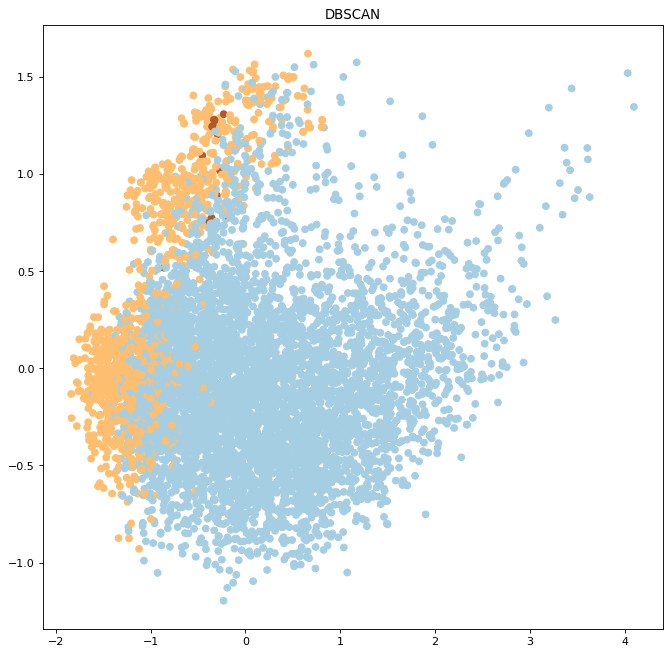

In [538]:
pca = PCA(n_components=2).fit_transform(precomputed)

plt.figure(figsize=(10, 10), dpi=80)


plt.scatter(pca[:,0], pca[:,1],c=dbscan_clusters, cmap='Paired')


plt.title("DBSCAN")
plt.show()

In [468]:
feature2['dbscan_cluster'] = dbscan_clusters

In [478]:
feature2.columns

Index(['days_on_market', 'sold_price/sqft', 'zip_code', 'sfheatcool',
       'year_built', 'bedrooms', '#_of_garage_spaces', 'parcel_size_(acres)',
       'how_sold_code_CASH', 'how_sold_code_CONVENTIONAL',
       ...
       'roof_Rock or Gravel', 'roof_Rolled', 'roof_Rolled Shingle',
       'roof_Shingle', 'roof_Shingle - Asbestos', 'roof_Shingle Other',
       'roof_Shingle Tile', 'roof_Tile', 'total_bath', 'dbscan_cluster'],
      dtype='object', length=169)

In [479]:
pd.set_option('display.max_columns', 500)
feature2.groupby('dbscan_cluster').mean()

,days_on_market,sold_price/sqft,zip_code,sfheatcool,year_built,bedrooms,#_of_garage_spaces,parcel_size_(acres),how_sold_code_CASH,how_sold_code_CONVENTIONAL,how_sold_code_CONVENTIONAL REHAB,how_sold_code_FHA,how_sold_code_FHA 203K REHAB,how_sold_code_OTHER,how_sold_code_PRIVATE,how_sold_code_SELLER,how_sold_code_USDA,how_sold_code_VA,condition_New Construction,condition_Other,condition_Under Construction,bathroom_features_Exhaust Fan Single Vanity,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo Walk-In Shower,bathroom_features_Exhaust Fan Tub/Shower Combo,bathroom_features_Multiple,bathroom_features_None,bathroom_features_Single Vanity,bathroom_features_Single Vanity Tub/Shower Combo,bathroom_features_Single Vanity Tub/Shower Combo Walk-In Shower,bathroom_features_Single Vanity Walk-In Shower,bathroom_features_Sink - Dual,bathroom_features_Sink - Dual Walk-In Shower,bathroom_features_Tub/Shower Combo,bathroom_features_Tub/Shower Combo Walk-In Shower,bathroom_features_Walk-In Shower,lot_info_Corner Lot Wooded Lot,lot_info_Cul-de-sac,lot_info_Cul-de-sac Wooded Lot,lot_info_Irregular,lot_info_Mostly Cleared/Grass,lot_info_Mostly Cleared/Grass Rectangular-shaped,lot_info_Multiple,lot_info_Other,lot_info_Other Sidewalks,lot_info_Rectangular-shaped,lot_info_Rectangular-shaped Sidewalks,lot_info_Rectangular-shaped Wooded Lot,lot_info_Sidewalks,lot_info_Square-shaped,lot_info_Wooded Lot,terms_Cash Conventional,terms_Cash Conventional FHA,terms_Cash Conventional FHA May Pay Closing Costs Title Ins Provided VA,terms_Cash Conventional FHA Sold As Is VA,terms_Cash Conventional FHA Title Ins Provided VA,terms_Cash Conventional FHA USDA VA,terms_Cash Conventional FHA VA,terms_Cash Conventional Sold As Is,terms_Cash Conventional Title Ins Provided,terms_Cash Conventional VA,terms_Cash FHA,terms_Multiple,terms_Other,terms_Sold As Is,terms_Title Ins Provided,interior_layout_Family Room,interior_layout_Family Room Foyer Laundry/Utility Room Living Room,interior_layout_Family Room Foyer Laundry/Utility Room Living Room Master Downstairs,interior_layout_Family Room Laundry/Utility Room,interior_layout_Foyer Great Room Laundry/Utility Room,interior_layout_Foyer Great Room Laundry/Utility Room Master Downstairs,interior_layout_Foyer Great Room Laundry/Utility Room Master Downstairs Pantry,interior_layout_Foyer Great Room Laundry/Utility Room Pantry,interior_layout_Great Room,interior_layout_Great Room Laundry/Utility Room,interior_layout_Laundry in Garage,interior_layout_Laundry in Garage Living Room,interior_layout_Laundry/Utility Room,interior_layout_Laundry/Utility Room Living Room,interior_layout_Laundry/Utility Room Living Room Master Downstairs,interior_layout_Living Room,interior_layout_Multiple,interior_layout_Other,floors_Carpet Luxury Vinyl Planking,floors_Carpet Luxury Vinyl Planking Tile,floors_Carpet Tile,floors_Carpet Tile Vinyl,floors_Carpet Tile Wood - Hardwood,floors_Carpet Tile Wood - Laminate,floors_Carpet Vinyl,floors_Carpet Wood - Hardwood,floors_Carpet Wood - Laminate,floors_Multiple,floors_No Carpeting Tile Wood - Hardwood,floors_No Carpeting Tile Wood - Laminate,floors_Other,floors_Tile,floors_Tile Wood - Hardwood,floors_Tile Wood - Laminate,floors_Wood - Hardwood,floors_Wood - Laminate,style_2 Story Contemporary,style_Contemporary,style_Craftsman,style_Craftsman Traditional,style_Mid-Century Modern,style_Multiple,style_Other,style_Ranch,style_Traditional,outbuilding_features_None,outbuilding_features_Other,outbuilding_features_Storage Shed,outbuilding_features_Workshop,fencing_Chain Link Wood,fencing_Complete Perimeter Wood,fencing_Mixed Type,fencing_Multiple,fencing_None,fencing_Other,fencing_Partial,fencing_Partial Wood,fencing_Privacy,fencing_Privacy Wood,fencing_Wood,appliances/equipment_Cooktop - Electric Dishwasher Disposal Microwave Oven - Electric Refrigerator,appliances/equipment_Cooktop - Electric Dishwasher Oven - Electric Refrigerator,appl

In [484]:
key_variables = ['dbscan_cluster','days_on_market', 'sold_price/sqft', 'sfheatcool', 'year_built'
                 ,'parcel_size_(acres)', 'condition_New Construction', 'condition_Other', 
                 'construction_type_Foundation-Slab Frame', 'construction_type_Frame',  
                 'exterior_finish_Hardiboard/Concr Siding', 'fencing_None',  'fencing_Multiple', 
                 'style_Multiple', 'floors_Carpet Tile Wood - Laminate', 'floors_Carpet Tile Wood - Hardwood', 
                 'interior_layout_Foyer Great Room Laundry/Utility Room Pantry', 'lot_info_Rectangular-shaped',
                 'lot_info_Rectangular-shaped Sidewalks']

dbscan_df = feature2[key_variables]

# Hierarchical 

Working with the other two models I want to drop outliers. Going back to an earlier version of the DF, features_df, to access sales price to sort outliers more effectively

In [487]:
features_df.columns

Index(['list_price', 'selling_price', 'days_on_market', 'list_price_/_sqft',
       'sold_price/sqft', 'how_sold_code', 'zip_code', 'sfheatcool',
       'year_built', 'baths', 'bedrooms', 'half-baths', 'condition',
       '#_of_garage_spaces', 'garage_y/n', 'pool_y/n', 'roof',
       'construction_type', 'exterior_finish', 'bathroom_features',
       'appliances/equipment', 'fencing', 'outbuilding_features', 'style',
       'floors', 'interior_layout', 'terms', 'lot_info', 'parcel_size_(acres)',
       'bathroom_features_truncated', 'lot_info_truncated', 'terms_truncated',
       'interior_layout_truncated', 'floors_truncated', 'style_truncated',
       'outbuilding_features_truncated', 'fencing_truncated',
       'appliances/equipment_truncated', 'exterior_finish_truncated',
       'construction_type_truncated', 'roof_truncated'],
      dtype='object')

In [488]:
model_df = features_df.loc[(features_df['selling_price'] < 1200000)]
model_df = features_df.loc[(features_df['selling_price'] > 50000)]

model_df = model_df.drop(columns = ['list_price', 'selling_price', 'list_price_/_sqft', 'garage_y/n', 'pool_y/n'])

In [489]:
model_df.columns

Index(['days_on_market', 'sold_price/sqft', 'how_sold_code', 'zip_code',
       'sfheatcool', 'year_built', 'baths', 'bedrooms', 'half-baths',
       'condition', '#_of_garage_spaces', 'roof', 'construction_type',
       'exterior_finish', 'bathroom_features', 'appliances/equipment',
       'fencing', 'outbuilding_features', 'style', 'floors', 'interior_layout',
       'terms', 'lot_info', 'parcel_size_(acres)',
       'bathroom_features_truncated', 'lot_info_truncated', 'terms_truncated',
       'interior_layout_truncated', 'floors_truncated', 'style_truncated',
       'outbuilding_features_truncated', 'fencing_truncated',
       'appliances/equipment_truncated', 'exterior_finish_truncated',
       'construction_type_truncated', 'roof_truncated'],
      dtype='object')

In [490]:
model_df = model_df.drop(columns = redundant2)

model_df.columns = model_df.columns.str.replace('_truncated', '')

model_df['total_bath'] = model_df['baths'] + (model_df['half-baths']/2)

model_df = model_df.drop(columns = ['baths', 'half-baths'])

In [491]:
model_df = pd.get_dummies(model_df)

In [492]:
X1 = model_df

Scaler = std()

X_scaled1 = Scaler.fit_transform(X1)

precomputed = gower.gower_matrix(X_scaled1)

In [493]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='precomputed',
                                      n_clusters=3)

# Fit model
agg_clusters = agg_cluster.fit_predict(precomputed)

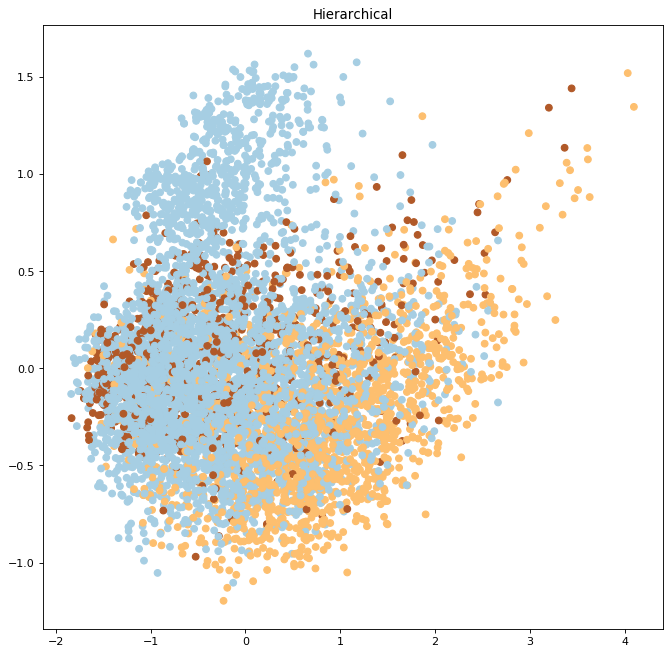

In [537]:
pca = PCA(n_components=2).fit_transform(precomputed)
plt.figure(figsize=(10, 10), dpi=80)

plt.scatter(pca[:,0], pca[:,1],c=agg_clusters, cmap='Paired')
plt.title("Hierarchical")

plt.show()

# Gaussian Mixture Models

In [495]:
# Defining the gaussian clustering
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
gmm_clusters = gmm_cluster.fit_predict(X_scaled1)

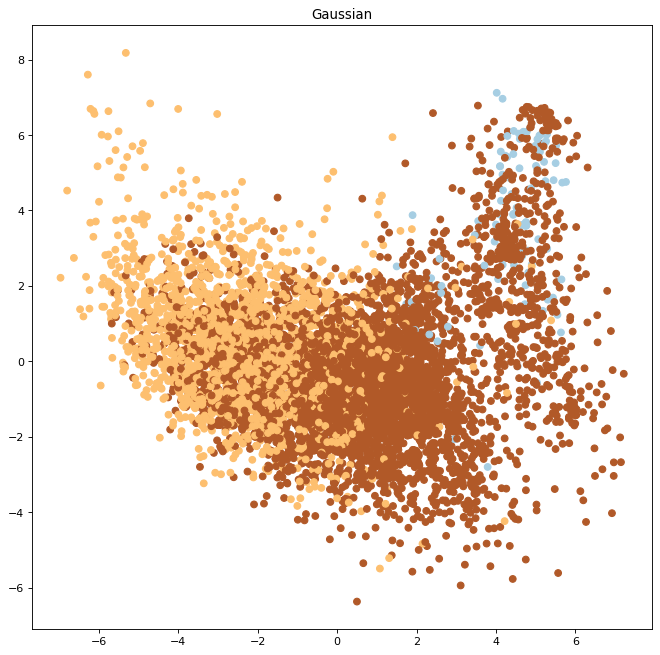

In [536]:
pca = PCA(n_components=2).fit_transform(X_scaled1)

plt.figure(figsize=(10, 10), dpi=80)

plt.scatter(pca[:,0], pca[:,1],c=gmm_clusters, cmap='Paired')
plt.title("Gaussian")
# plt.figure(figsize=(10,5))
# colours = 'rbg'
# for i in range(pca.shape[0]):
#     plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
#              fontdict={'weight': 'bold', 'size': 50}
#         )

# plt.xticks([])
# plt.yticks([])
# plt.axis('off')
plt.show()

In [497]:
model_df['agg_cluster'] = agg_clusters


model_df['gmm_cluster'] = gmm_clusters

In [498]:
model_df.groupby('agg_cluster').mean()

,days_on_market,sold_price/sqft,zip_code,sfheatcool,year_built,bedrooms,#_of_garage_spaces,parcel_size_(acres),total_bath,how_sold_code_ASSUMPTION,how_sold_code_CASH,how_sold_code_CONVENTIONAL,how_sold_code_CONVENTIONAL REHAB,how_sold_code_FHA,how_sold_code_FHA 203K REHAB,how_sold_code_OTHER,how_sold_code_PRIVATE,how_sold_code_SELLER,how_sold_code_USDA,how_sold_code_VA,condition_Handyman Special,condition_New Construction,condition_Other,condition_Under Construction,bathroom_features_Exhaust Fan,bathroom_features_Exhaust Fan Single Vanity,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo Walk-In Shower,bathroom_features_Exhaust Fan Tub/Shower Combo,bathroom_features_Multiple,bathroom_features_None,bathroom_features_Single Vanity,bathroom_features_Single Vanity Tub/Shower Combo,bathroom_features_Single Vanity Tub/Shower Combo Walk-In Shower,bathroom_features_Single Vanity Walk-In Shower,bathroom_features_Sink - Dual,bathroom_features_Sink - Dual Walk-In Shower,bathroom_features_Tub/Shower Combo,bathroom_features_Tub/Shower Combo Walk-In Shower,bathroom_features_Walk-In Shower,lot_info_Corner Lot,lot_info_Corner Lot Wooded Lot,lot_info_Cul-de-sac,lot_info_Cul-de-sac Wooded Lot,lot_info_Irregular,lot_info_Mostly Cleared/Grass,lot_info_Mostly Cleared/Grass Rectangular-shaped,lot_info_Multiple,lot_info_Other,lot_info_Other Sidewalks,lot_info_Rectangular-shaped,lot_info_Rectangular-shaped Sidewalks,lot_info_Rectangular-shaped Wooded Lot,lot_info_Sidewalks,lot_info_Square-shaped,lot_info_Wooded Lot,terms_Cash,terms_Cash Conventional,terms_Cash Conventional FHA,terms_Cash Conventional FHA May Pay Closing Costs Title Ins Provided VA,terms_Cash Conventional FHA Sold As Is VA,terms_Cash Conventional FHA Title Ins Provided VA,terms_Cash Conventional FHA USDA VA,terms_Cash Conventional FHA VA,terms_Cash Conventional Sold As Is,terms_Cash Conventional Title Ins Provided,terms_Cash Conventional VA,terms_Cash FHA,terms_Multiple,terms_Other,terms_Sold As Is,terms_Title Ins Provided,interior_layout_Den/Ofc (Not Inc in Bd #) Foyer Great Room Laundry/Utility Room Pantry,interior_layout_Family Room,interior_layout_Family Room Foyer Laundry/Utility Room Living Room,interior_layout_Family Room Foyer Laundry/Utility Room Living Room Master Downstairs,interior_layout_Family Room Laundry/Utility Room,interior_layout_Foyer Great Room Laundry/Utility Room,interior_layout_Foyer Great Room Laundry/Utility Room Master Downstairs,interior_layout_Foyer Great Room Laundry/Utility Room Master Downstairs Pantry,interior_layout_Foyer Great Room Laundry/Utility Room Pantry,interior_layout_Great Room,interior_layout_Great Room Laundry/Utility Room,interior_layout_Laundry in Garage,interior_layout_Laundry in Garage Living Room,interior_layout_Laundry/Utility Room,interior_layout_Laundry/Utility Room Living Room,interior_layout_Laundry/Utility Room Living Room Master Downstairs,interior_layout_Living Room,interior_layout_Multiple,interior_layout_Other,floors_Carpet,floors_Carpet Luxury Vinyl Planking,floors_Carpet Luxury Vinyl Planking Tile,floors_Carpet Tile,floors_Carpet Tile Vinyl,floors_Carpet Tile Wood - Hardwood,floors_Carpet Tile Wood - Laminate,floors_Carpet Vinyl,floors_Carpet Wood - Hardwood,floors_Carpet Wood - Laminate,floors_Multiple,floors_No Carpeting Tile Wood - Hardwood,floors_No Carpeting Tile Wood - Laminate,floors_Other,floors_Tile,floors_Tile Wood - Hardwood,floors_Tile Wood - Laminate,floors_Wood - Hardwood,floors_Wood - Laminate,style_2 Story,style_2 Story Contemporary,style_Contemporary,style_Craftsman,style_Craftsman Traditional,style_Mid-Century Modern,style_Multiple,style_Other,style_Ranch,style_Traditional,outbuilding_features_Multiple,outbuilding_features_None,outbuilding_features_Other,outbuilding_features_Storage Shed,outbuilding_features_Workshop,fencing_Chain Link,fencing_Chain Link Wood,fencing_Complete Perimeter Wood,fencing_Mixed Type,fencing_Multiple,fencing_N

In [499]:
model_df.groupby('gmm_cluster').mean()

,days_on_market,sold_price/sqft,zip_code,sfheatcool,year_built,bedrooms,#_of_garage_spaces,parcel_size_(acres),total_bath,how_sold_code_ASSUMPTION,how_sold_code_CASH,how_sold_code_CONVENTIONAL,how_sold_code_CONVENTIONAL REHAB,how_sold_code_FHA,how_sold_code_FHA 203K REHAB,how_sold_code_OTHER,how_sold_code_PRIVATE,how_sold_code_SELLER,how_sold_code_USDA,how_sold_code_VA,condition_Handyman Special,condition_New Construction,condition_Other,condition_Under Construction,bathroom_features_Exhaust Fan,bathroom_features_Exhaust Fan Single Vanity,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo,bathroom_features_Exhaust Fan Single Vanity Tub/Shower Combo Walk-In Shower,bathroom_features_Exhaust Fan Tub/Shower Combo,bathroom_features_Multiple,bathroom_features_None,bathroom_features_Single Vanity,bathroom_features_Single Vanity Tub/Shower Combo,bathroom_features_Single Vanity Tub/Shower Combo Walk-In Shower,bathroom_features_Single Vanity Walk-In Shower,bathroom_features_Sink - Dual,bathroom_features_Sink - Dual Walk-In Shower,bathroom_features_Tub/Shower Combo,bathroom_features_Tub/Shower Combo Walk-In Shower,bathroom_features_Walk-In Shower,lot_info_Corner Lot,lot_info_Corner Lot Wooded Lot,lot_info_Cul-de-sac,lot_info_Cul-de-sac Wooded Lot,lot_info_Irregular,lot_info_Mostly Cleared/Grass,lot_info_Mostly Cleared/Grass Rectangular-shaped,lot_info_Multiple,lot_info_Other,lot_info_Other Sidewalks,lot_info_Rectangular-shaped,lot_info_Rectangular-shaped Sidewalks,lot_info_Rectangular-shaped Wooded Lot,lot_info_Sidewalks,lot_info_Square-shaped,lot_info_Wooded Lot,terms_Cash,terms_Cash Conventional,terms_Cash Conventional FHA,terms_Cash Conventional FHA May Pay Closing Costs Title Ins Provided VA,terms_Cash Conventional FHA Sold As Is VA,terms_Cash Conventional FHA Title Ins Provided VA,terms_Cash Conventional FHA USDA VA,terms_Cash Conventional FHA VA,terms_Cash Conventional Sold As Is,terms_Cash Conventional Title Ins Provided,terms_Cash Conventional VA,terms_Cash FHA,terms_Multiple,terms_Other,terms_Sold As Is,terms_Title Ins Provided,interior_layout_Den/Ofc (Not Inc in Bd #) Foyer Great Room Laundry/Utility Room Pantry,interior_layout_Family Room,interior_layout_Family Room Foyer Laundry/Utility Room Living Room,interior_layout_Family Room Foyer Laundry/Utility Room Living Room Master Downstairs,interior_layout_Family Room Laundry/Utility Room,interior_layout_Foyer Great Room Laundry/Utility Room,interior_layout_Foyer Great Room Laundry/Utility Room Master Downstairs,interior_layout_Foyer Great Room Laundry/Utility Room Master Downstairs Pantry,interior_layout_Foyer Great Room Laundry/Utility Room Pantry,interior_layout_Great Room,interior_layout_Great Room Laundry/Utility Room,interior_layout_Laundry in Garage,interior_layout_Laundry in Garage Living Room,interior_layout_Laundry/Utility Room,interior_layout_Laundry/Utility Room Living Room,interior_layout_Laundry/Utility Room Living Room Master Downstairs,interior_layout_Living Room,interior_layout_Multiple,interior_layout_Other,floors_Carpet,floors_Carpet Luxury Vinyl Planking,floors_Carpet Luxury Vinyl Planking Tile,floors_Carpet Tile,floors_Carpet Tile Vinyl,floors_Carpet Tile Wood - Hardwood,floors_Carpet Tile Wood - Laminate,floors_Carpet Vinyl,floors_Carpet Wood - Hardwood,floors_Carpet Wood - Laminate,floors_Multiple,floors_No Carpeting Tile Wood - Hardwood,floors_No Carpeting Tile Wood - Laminate,floors_Other,floors_Tile,floors_Tile Wood - Hardwood,floors_Tile Wood - Laminate,floors_Wood - Hardwood,floors_Wood - Laminate,style_2 Story,style_2 Story Contemporary,style_Contemporary,style_Craftsman,style_Craftsman Traditional,style_Mid-Century Modern,style_Multiple,style_Other,style_Ranch,style_Traditional,outbuilding_features_Multiple,outbuilding_features_None,outbuilding_features_Other,outbuilding_features_Storage Shed,outbuilding_features_Workshop,fencing_Chain Link,fencing_Chain Link Wood,fencing_Complete Perimeter Wood,fencing_Mixed Type,fencing_Multiple,fencing_N

In [501]:
gmm_features = ['gmm_cluster', 'days_on_market', 'sold_price/sqft', 'sfheatcool', 'year_built', '#_of_garage_spaces', 'parcel_size_(acres)', 'condition_New Construction', 'interior_layout_Den/Ofc (Not Inc in Bd #) Foyer Great Room Laundry/Utility Room Pantry', 'style_Craftsman', 'outbuilding_features_None', 'exterior_finish_Hardiboard/Concr Siding', 'construction_type_Foundation-Slab Frame', 'construction_type_Frame']

gmm_df = model_df[gmm_features]

In [505]:
agg_features = ['agg_cluster','construction_type_Concrete Block', 'construction_type_Frame', 
                'outbuilding_features_None', 'outbuilding_features_Storage Shed', 
                'style_Ranch', 'parcel_size_(acres)', '#_of_garage_spaces', 'year_built',
                'sfheatcool', 'sold_price/sqft', 'days_on_market']

agg_df = model_df[agg_features]

## Investigating Variables after clustering

## DBSCAN Analysis

In [486]:
dbscan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362 entries, 2 to 6903
Data columns (total 19 columns):
dbscan_cluster                                                  6362 non-null int64
days_on_market                                                  6362 non-null int64
sold_price/sqft                                                 6362 non-null float64
sfheatcool                                                      6362 non-null int64
year_built                                                      6362 non-null int64
parcel_size_(acres)                                             6362 non-null float64
condition_New Construction                                      6362 non-null uint8
condition_Other                                                 6362 non-null uint8
construction_type_Foundation-Slab Frame                         6362 non-null uint8
construction_type_Frame                                         6362 non-null uint8
exterior_finish_Hardiboard/Concr Siding          

In [514]:
dbscan_df.groupby('dbscan_cluster').describe()

days_on_market                                              \
                        count        mean         std   min    25%    50%   
dbscan_cluster                                                              
-1                     5288.0   93.840204   95.352360   0.0   44.0   65.0   
 0                     1052.0  140.240494  117.368321   0.0   56.0  105.0   
 1                       14.0  201.571429   88.518329  76.0  119.0  210.5   
 2                        8.0  110.000000   57.153927  36.0   57.5  112.5   

                               sold_price/sqft                                 \
                   75%     max           count        mean        std     min   
dbscan_cluster                                                                  
-1              112.00  2443.0          5288.0  128.033419  34.312732   11.77   
 0              193.00   813.0          1052.0  155.247709  30.703327   40.98   
 1              268.25   366.0            14.0  169.776429  17.756727  149.43   
 2              149.25   196.0             8.0  144.176250  23.584577  122.01   

                                                    sfheatcool               \
                     25%      50%       75%     max      count         mean   
dbscan_cluster                                                                
-1              108.7475  126.830  146.1150  409.15     5288.0  1891.789334   
 0              134.1675  149.145  171.9150  310.94     1052.0  2169.952471   
 1              158.6075  163.260  181.3175  209.52       14.0  1722.785714   
 2              127.5225  135.705  152.0125  183.97        8.0  2992.750000   

                                                                      \
                        std     min      25%     50%     75%     max   
dbscan_cluster                                                         
-1               773.825156   528.0  1348.00  1718.0  2233.0  5978.0   
 0               672.349918  1185.0  1681.00  1979.0  2509.0  5215.0   
 1                42.874017  1620.0  1690.25  1750.0  1750.0  1750.0   
 2              1254.853634  1380.0  2331.00  2709.0  3934.5  4680.0   

               year_built                                                   \
                    count         mean        std     min      25%     50%   
dbscan_cluster                                                               
-1                 5288.0  1983.020234  20.793557  1874.0  1969.00  1983.0   
 0                 1052.0  2008.322243  11.133126  1951.0  2001.00  2012.0   
 1                   14.0  2018.214286   0.699293  2017.0  2018.00  2018.0   
 2                    8.0  1998.875000  11.655011  1983.0  1993.25  1999.0   

                               parcel_size_(acres)                           \
                   75%     max               count      mean       std  min   
dbscan_cluster                                                                
-1              2000.0  2020.0              5288.0  0.558270  1.232324  0.0   
 0              2018.0  2020.0              1052.0  0.283641  0.393273  0.0   
 1              2019.0  2019.0                14.0  0.130000  0.048038  0.1   
 2              2005.0  2019.0                 8.0  0.700000  0.675214  0.0   

                                            condition_New Construction  \
                   25%   50%     75%    max                      count   
dbscan_cluster                                                           
-1              0.2000  0.28  0.4000  20.00                     5288.0   
 0              0.1500  0.19  0.3000   9.40                     1052.0   
 1              0.1000  0.10  0.1675   0.25                       14.0   
 2              0.1325  0.54  1.1375   1.76                        8.0   

                                                            condition_Other  \
                    mean       std  min  25%  50%  75%  max           count   
dbscan_cluster                                                        

In [517]:
dbscan_df.groupby('dbscan_cluster').mean()

,days_on_market,sold_price/sqft,sfheatcool,year_built,parcel_size_(acres),condition_New Construction,condition_Other,construction_type_Foundation-Slab Frame,construction_type_Frame,exterior_finish_Hardiboard/Concr Siding,fencing_None,fencing_Multiple,style_Multiple,floors_Carpet Tile Wood - Laminate,floors_Carpet Tile Wood - Hardwood,interior_layout_Foyer Great Room Laundry/Utility Room Pantry,lot_info_Rectangular-shaped,lot_info_Rectangular-shaped Sidewalks
dbscan_cluster,,,,,,,,,,,,,,,,,,
-1,93.840204,128.033419,1891.789334,1983.020234,0.558270,0.041225,0.937784,0.147126,0.311271,0.211611,0.187595,0.163767,0.218419,0.076399,0.115545,0.009834,0.202723,0.024206
0,140.240494,155.247709,2169.952471,2008.322243,0.283641,0.370722,0.580798,0.340304,0.525665,0.704373,0.458175,0.030418,0.171103,0.071293,0.307985,0.003802,0.141635,0.052281
1,201.571429,169.776429,1722.785714,2018.214286,0.130000,0.928571,0.000000,1.000000,0.000000,1.000000,0.428571,0.500000,0.714286,0.000000,0.714286,0.000000,0.214286,0.785714
2,110.000000,144.176250,2992.750000,1998.875000,0.700000,0.000000,0.875000,0.000000,0.625000,0.000000,0.875000,0.000000,1.000000,0.000000,0.750000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'sold price / sqft')

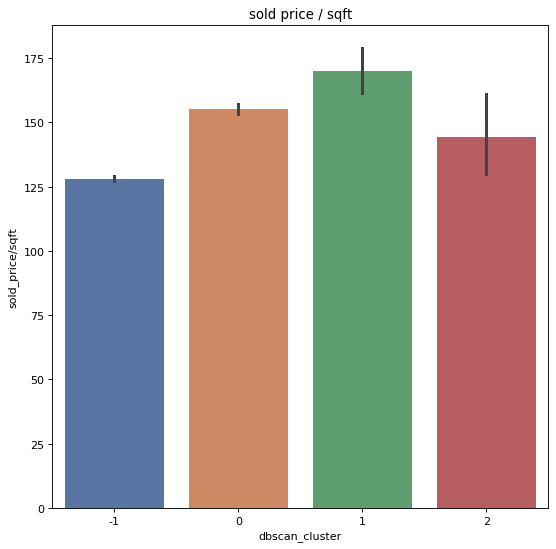

In [622]:
plt.figure(figsize=(8, 8), dpi=80)

sns.barplot(dbscan_df["dbscan_cluster"], dbscan_df["sold_price/sqft"], palette = 'deep')

plt.title("sold price / sqft")

Text(0.5, 1.0, 'Square Feet')

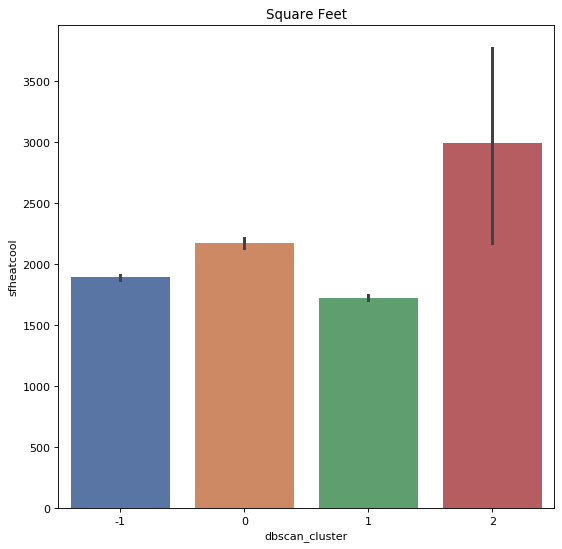

In [623]:
plt.figure(figsize=(8, 8), dpi=80)

sns.barplot(dbscan_df["dbscan_cluster"], dbscan_df["sfheatcool"], palette = 'deep')
plt.title("Square Feet")

Text(0.5, 1.0, 'acres')

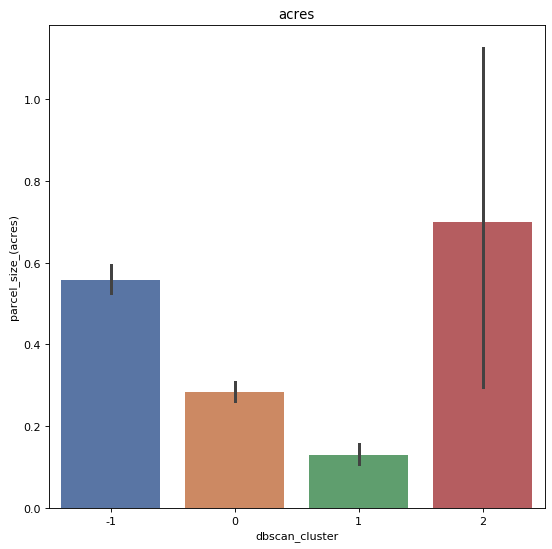

In [624]:
plt.figure(figsize=(8, 8), dpi=80)


sns.barplot(dbscan_df["dbscan_cluster"], dbscan_df["parcel_size_(acres)"], palette = 'deep')
plt.title("acres")

Text(0.5, 1.0, 'New Construction')

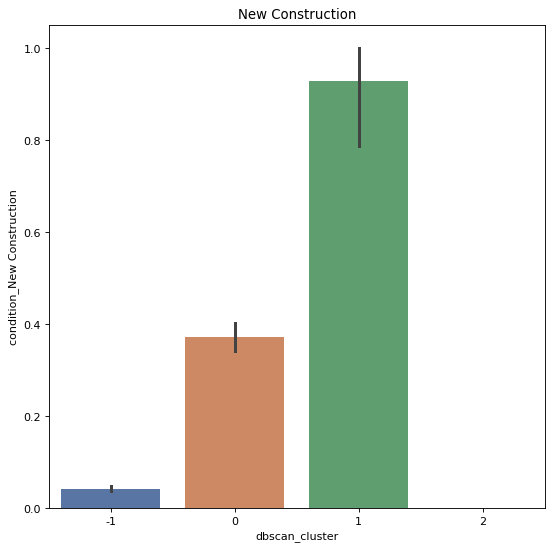

In [625]:
plt.figure(figsize=(8, 8), dpi=80)


sns.barplot(dbscan_df["dbscan_cluster"], dbscan_df["condition_New Construction"], palette = 'deep')
plt.title("New Construction")

Text(0.5, 1.0, 'multiple styles')

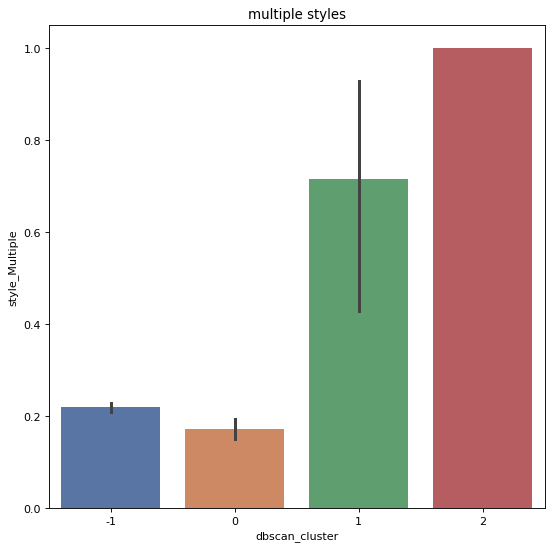

In [626]:
plt.figure(figsize=(8, 8), dpi=80)


sns.barplot(dbscan_df["dbscan_cluster"], dbscan_df["style_Multiple"], palette = 'deep')
plt.title("multiple styles")

Text(0.5, 1.0, 'year built')

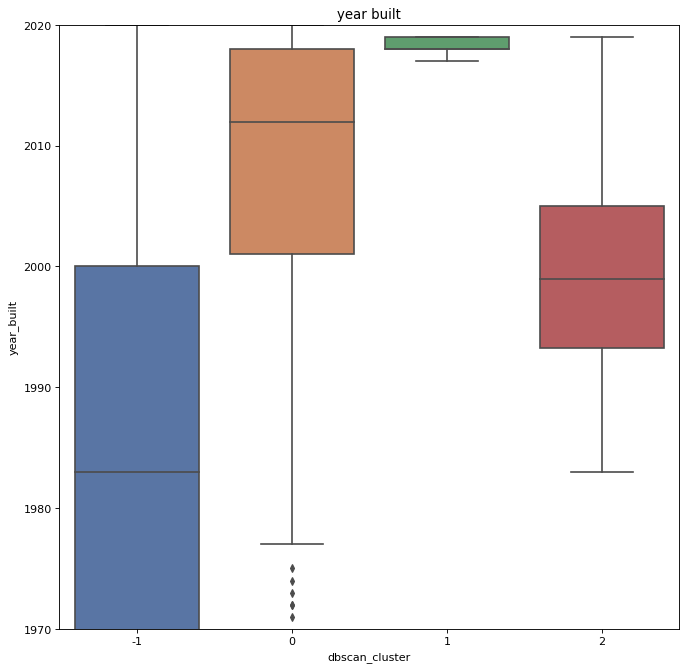

In [629]:
plt.figure(figsize=(10, 10), dpi=80)


sns.boxplot(dbscan_df["dbscan_cluster"], dbscan_df["year_built"], palette = 'deep')

plt.ylim(bottom=1970, top=2020)
plt.title("year built")

In [593]:
dbscan_df['dbscan_cluster'].value_counts()

-1    5288
 0    1052
 1      14
 2       8
Name: dbscan_cluster, dtype: int64

Running a few visuals on the points and examing the descriptive statistics create a better picture of this particular grouping.

It appears:
* -1 = The majority of houses in town fall within this category. On average they are the oldest house and sell for the lowest cost/sqft. However, the average days on market is the fastest and they have the (on average) second highest average acreage at .5 acres. Other than that they don't have any particularly distinguishing characteristics. Count of 5288

* 0 = Gentrification. These houses are newer, but not always with some older houses in the subset likely from the new wave of renovations occuring in gentrified parts of town. These areas either see homes constructed on vacant lots or renovated. They have the second highest average price per square foot and heated / cooled square feet. They also have the second longest average time on market, which is likely reflective of their pricing. They also have about an average of 40% new constructions. Count of 1052

* 1 = New Construction. On average 93% of homes in this cluster are new constructions, with the remaining being less than 10yrs old. These homes have the lowest average amount of acreage, which tells me they are being built likely in planned developments or in urban cores. They all have construction foundations of slab frames, which is likely due to new coding standards and all have concrete siding. Count of 14 & consistent elements of construction likely means they belong to the same development.  

* 2 = The luxury. These houses have the second lowest price per square foot, however due to the average square feet they are the most expensive on average. They also have the highest amount of average acres which reflects larger lots typically held by the wealthy. This class is the only one with no new constructions, which means these larger luxury homes are selling (at a low rate) and aren't the target for new developments. 


DBSCAN did a fantastic job using categorical variables and handling outliers, however there is a substantial imbalance in the clustering data.

## Hierarchical Analysis

In [506]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6295 entries, 118 to 6903
Data columns (total 12 columns):
agg_cluster                          6295 non-null int64
construction_type_Concrete Block     6295 non-null uint8
construction_type_Frame              6295 non-null uint8
outbuilding_features_None            6295 non-null uint8
outbuilding_features_Storage Shed    6295 non-null uint8
style_Ranch                          6295 non-null uint8
parcel_size_(acres)                  6295 non-null float64
#_of_garage_spaces                   6295 non-null float64
year_built                           6295 non-null int64
sfheatcool                           6295 non-null int64
sold_price/sqft                      6295 non-null float64
days_on_market                       6295 non-null int64
dtypes: float64(3), int64(4), uint8(5)
memory usage: 424.2 KB


In [515]:
agg_df.groupby('agg_cluster').describe()

construction_type_Concrete Block                                \
                                       count      mean       std  min  25%   
agg_cluster                                                                  
0                                     3875.0  0.060129  0.237756  0.0  0.0   
1                                     1616.0  0.486386  0.499969  0.0  0.0   
2                                      804.0  0.041045  0.198517  0.0  0.0   

                           construction_type_Frame                           \
             50%  75%  max                   count      mean       std  min   
agg_cluster                                                                   
0            0.0  0.0  1.0                  3875.0  0.338581  0.473288  0.0   
1            0.0  1.0  1.0                  1616.0  0.174505  0.379661  0.0   
2            0.0  0.0  1.0                   804.0  0.732587  0.442885  0.0   

                                outbuilding_features_None                      \
             25%  50%  75%  max                     count      mean       std   
agg_cluster                                                                     
0            0.0  0.0  1.0  1.0                    3875.0  0.738323  0.439605   
1            0.0  0.0  0.0  1.0                    1616.0  0.531559  0.499157   
2            0.0  1.0  1.0  1.0                     804.0  0.854478  0.352846   

                                     outbuilding_features_Storage Shed  \
             min  25%  50%  75%  max                             count   
agg_cluster                                                              
0            0.0  0.0  1.0  1.0  1.0                            3875.0   
1            0.0  0.0  1.0  1.0  1.0                            1616.0   
2            0.0  1.0  1.0  1.0  1.0                             804.0   

                                                         style_Ranch  \
                 mean       std  min  25%  50%  75%  max       count   
agg_cluster                                                            
0            0.106323  0.308290  0.0  0.0  0.0  0.0  1.0      3875.0   
1            0.277847  0.448076  0.0  0.0  0.0  1.0  1.0      1616.0   
2            0.069652  0.254718  0.0  0.0  0.0  0.0  1.0       804.0   

                                                         parcel_size_(acres)  \
                 mean       std  min  25%  50%  75%  max               count   
agg_cluster                                                                    
0            0.132903  0.339514  0.0  0.0  0.0  0.0  1.0              3875.0   
1            0.533416  0.499037  0.0  0.0  1.0  1.0  1.0              1616.0   
2            0.135572  0.342547  0.0  0.0  0.0  0.0  1.0               804.0   

                                                              \
                 mean       std  min   25%   50%   75%   max   
agg_cluster                                                    
0            0.567690  1.229157  0.0  0.18  0.26  0.45  20.0   
1            0.465582  1.121301  0.0  0.22  0.26  0.34  20.0   
2            0.329353  0.451016  0.0  0.16  0.23  0.33   5.8   

            #_of_garage_spaces                                               \
                         count      mean       std  min  25%  50%  75%  max   
agg_cluster                                                                   
0                       3875.0  1.731355  0.865703  0.0  2.0  2.0  2.0  4.0   
1                       1616.0  0.878713  0.934455  0.0  0.0  1.0  2.0  4.0   
2                        804.0  1.680348  0.732496  0.0  2.0  2.0  2.0  4.0   

            year_built                                                  \
                 count         mean        std     min     25%     50%   
agg_cluster                                                              
0               3875.0  1992.948387  21.280532  1874.0  1980.0  1997.0   
1               1616.0  1971.981436  16.083902  1900.0  1960.0  19

In [518]:
agg_df.groupby('agg_cluster').mean()

,construction_type_Concrete Block,construction_type_Frame,outbuilding_features_None,outbuilding_features_Storage Shed,style_Ranch,parcel_size_(acres),#_of_garage_spaces,year_built,sfheatcool,sold_price/sqft,days_on_market
agg_cluster,,,,,,,,,,,
0,0.060129,0.338581,0.738323,0.106323,0.132903,0.567690,1.731355,1992.948387,2136.408000,141.060325,111.932129
1,0.486386,0.174505,0.531559,0.277847,0.533416,0.465582,0.878713,1971.981436,1572.938119,117.354827,84.154084
2,0.041045,0.732587,0.854478,0.069652,0.135572,0.329353,1.680348,1992.901741,1802.134328,130.401169,83.763682


Text(0.5, 1.0, 'acres')

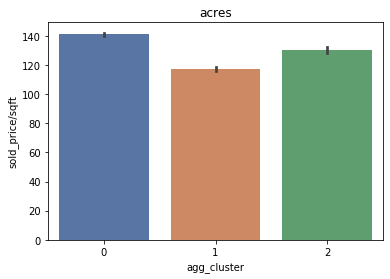

In [628]:
sns.barplot(agg_df["agg_cluster"], agg_df["sold_price/sqft"], palette = 'deep')
plt.title("acres")

After reviewing details of Hierarchical clustering, I can't see any interpretable elements that distinguish one cluster significantly from the other. There may have been some issues with the clustering since there was such a large number of categorical variables involved.

## Gaussian Mixture Analysis

In [504]:
gmm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6295 entries, 118 to 6903
Data columns (total 14 columns):
gmm_cluster                                                                               6295 non-null int64
days_on_market                                                                            6295 non-null int64
sold_price/sqft                                                                           6295 non-null float64
sfheatcool                                                                                6295 non-null int64
year_built                                                                                6295 non-null int64
#_of_garage_spaces                                                                        6295 non-null float64
parcel_size_(acres)                                                                       6295 non-null float64
condition_New Construction                                                                6295 non-null uint8
inter

In [516]:
gmm_df.groupby('gmm_cluster').describe()

days_on_market                                                    \
                     count        mean         std  min    25%    50%    75%   
gmm_cluster                                                                    
0                    102.0  172.000000  100.209088  0.0  75.75  186.0  247.5   
1                   1782.0   80.843434   77.363944  0.0  41.00   60.0   97.0   
2                   4411.0  107.791657  103.529944  0.0  47.00   74.0  135.0   

                    sold_price/sqft                                           \
                max           count        mean        std     min       25%   
gmm_cluster                                                                    
0             504.0           102.0  138.739706  14.948210  114.21  129.5550   
1            1327.0          1782.0  118.500034  31.332053   27.56  100.7825   
2            2443.0          4411.0  139.600587  33.600462   29.52  119.2950   

                                       sfheatcool                           \
                 50%       75%     max      count         mean         std   
gmm_cluster                                                                  
0            135.840  144.1775  196.22      102.0  2036.696078  323.477662   
1            118.255  135.7700  409.15     1782.0  1576.849607  563.190418   
2            136.490  156.6600  344.72     4411.0  2097.410111  788.264141   

                                                     year_built               \
                min      25%     50%     75%     max      count         mean   
gmm_cluster                                                                    
0            1182.0  1876.00  1974.0  2124.0  3768.0      102.0  2016.343137   
1             552.0  1201.25  1444.5  1800.0  5860.0     1782.0  1972.524691   
2             672.0  1538.50  1928.0  2475.0  5978.0     4411.0  1992.968488   

                                                                \
                   std     min     25%     50%     75%     max   
gmm_cluster                                                      
0             4.510703  1998.0  2017.0  2018.0  2018.0  2019.0   
1            18.568362  1896.0  1959.0  1972.0  1984.0  2019.0   
2            19.614347  1874.0  1980.0  1997.0  2007.0  2020.0   

            #_of_garage_spaces                                               \
                         count      mean       std  min  25%  50%  75%  max   
gmm_cluster                                                                   
0                        102.0  2.098039  0.330311  1.0  2.0  2.0  2.0  3.0   
1                       1782.0  0.903479  0.943490  0.0  0.0  1.0  2.0  4.0   
2                       4411.0  1.735661  0.837037  0.0  2.0  2.0  2.0  4.0   

            parcel_size_(acres)                                              \
                          count      mean       std   min   25%   50%   75%   
gmm_cluster                                                                   
0                         102.0  0.172157  0.080329  0.12  0.13  0.15  0.16   
1                        1782.0  0.510067  1.322254  0.00  0.21  0.26  0.34   
2                        4411.0  0.519265  1.060812  0.00  0.18  0.26  0.43   

                   condition_New Construction                                \
               max                      count      mean       std  min  25%   
gmm_cluster                                                                   
0             0.65                      102.0  0.735294  0.443355  0.0  0.0   
1            20.00                     1782.0  0.012907  0.112904  0.0  0.0   
2            20.00                     4411.0  0.118567  0.323315  0.0  0.0   

                            \
             50%  75%  max   
gmm_cluster                  
0            1.0  1.0  1.0   
1            0.0  0.0  1.0   
2            0.0  0.0  1.0   

            interior_layout_Den/Ofc (Not Inc in Bd #) Foyer Great Room Laundry/Utility Room Pantr

In [519]:
gmm_df.groupby('gmm_cluster').mean()

,days_on_market,sold_price/sqft,sfheatcool,year_built,#_of_garage_spaces,parcel_size_(acres),condition_New Construction,interior_layout_Den/Ofc (Not Inc in Bd #) Foyer Great Room Laundry/Utility Room Pantry,style_Craftsman,outbuilding_features_None,exterior_finish_Hardiboard/Concr Siding,construction_type_Foundation-Slab Frame,construction_type_Frame
gmm_cluster,,,,,,,,,,,,,
0,172.000000,138.739706,2036.696078,2016.343137,2.098039,0.172157,0.735294,0.519608,0.754902,1.000000,0.676471,0.745098,0.245098
1,80.843434,118.500034,1576.849607,1972.524691,0.903479,0.510067,0.012907,0.000000,0.022447,0.582492,0.115039,0.072952,0.230079
2,107.791657,139.600587,2097.410111,1992.968488,1.735661,0.519265,0.118567,0.000000,0.078894,0.740648,0.362049,0.214010,0.396282


I see a trend here similar to Hierarchical clustering

# Conclusion

DBSCAN was the best unsupervised learning algorithm as it effectively dealt with outliers and was best capable of handling the gower distance metric. I think the conclusions also support the demographics in Gainesville with the imbalanced data in favor of the cheaper houses. It also reflects trends I have been seeing over the past few years.